In [437]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
from matplotlib_venn import venn2
from venn import venn

sns.set_palette('colorblind')
sns.set_style('white') 
palette = sns.color_palette('colorblind', 6)

In [438]:
# Create dictionary to map gene ID to gene name
df = pd.read_csv('/Users/tk/Desktop/Research-CITS5014/Raw_gene_count/0a9e33db-2527-4cc3-8669-a7c10fed7a7f.rna_seq.augmented_star_gene_counts.tsv', delimiter='\t', header=1)
df = df.iloc[4:]
gene_id_to_name = dict(zip(df['gene_id'], df['gene_name']))

In [ ]:
df_with_subtype = pd.read_csv('/Users/tk/Desktop/gene_project/norm_pam50.csv', sep=',', index_col=0)
df_with_subtype.index.name = None

# Get survival time, status, and subtype from the dataframe
survival_time = pd.to_numeric(df_with_subtype.iloc[-3].values, errors='coerce')
status = pd.to_numeric(df_with_subtype.iloc[-2].values, errors='coerce')
subtypes = df_with_subtype.iloc[-1].values

### Use all samples to find optimal gene expression

In [387]:
def plot_distribution(list, real_val, gene, p_val):
    plt.figure(figsize=(6, 4))
    obs_color = palette[2]
    # min_color = palette[1]
    # max_color = palette[3]
    # Calculate min and max values
    # min = np.min(list)
    # max = np.max(list)
    # Plot histogram with KDE
    sns.histplot(list, bins=60, kde=True, edgecolor='black')
    plt.axvline(real_val, color=obs_color, linestyle='--', label=f'Observed JSD: {real_val:.4f}', linewidth=2) 
    # plt.axvline(min, color=min_color, linestyle='--', label=f'Min simulated KS statistic: {min:.4f}', linewidth=2)
    # plt.axvline(max, color=max_color, linestyle='--', label=f'Max simulated KS statistic: {max:.4f}', linewidth=2) 
    text = f'JS Divergence Estimated Null Distribution \n Gene: {gene_id_to_name.get(gene, gene)} (p = {p_val})' 
    plt.title(f'{text}', fontsize=10)
    plt.xlabel('JS Divergence')
    plt.ylabel('Frequency')
    plt.legend(fontsize=8)
    plt.grid()
    plt.show()

def bootstrap_test(survival_time, obs_stat, num_simulation):
    jsd_sim = []  
    epsilon = 1e-10
    
    for _ in range(num_simulation):   
        # Select a random split index
        split_index = np.random.randint(1, len(survival_time)//2)

        # Shuffle the data
        shuffled_data = survival_time.copy()
        np.random.shuffle(shuffled_data)

        # Divide the data based on the split index
        group1 = shuffled_data[:split_index]
        group2 = shuffled_data[split_index:]

        # Combine both time groups to get all unique time values
        all_times = set(group1).union(set(group2))

        # Calculate the probability distribution for each group
        p = pd.Series(group1).value_counts(normalize=True).reindex(all_times, fill_value=0)
        q = pd.Series(group2).value_counts(normalize=True).reindex(all_times, fill_value=0)
        p = np.clip(p, epsilon, None)
        q = np.clip(q, epsilon, None)
      
        # Compute the average distribution
        m = 0.5 * (p + q)
        
        # Calculate KL Divergences
        KL_P_M = np.sum(p * np.log(p / m))
        KL_Q_M = np.sum(q * np.log(q / m))
        
        # Calculate JS divergence
        JSD = 0.5 * (KL_P_M + KL_Q_M)
        jsd_sim.append(JSD)
    
    # Performing a one-sided test
    extreme_count = np.sum(np.array(jsd_sim) > obs_stat)
    p_value = extreme_count / len(jsd_sim)

    # Plot simulation distribution
    # plot_distribution(jsd_sim, obs_stat, gene, p_value.round(6))
    return jsd_sim, p_value.round(6)

In [481]:
# Read and sort the result by high JS divergence
jsd_result = pd.read_csv(f'./result3/jsd_All.csv', sep=',')
jsd_result = jsd_result[jsd_result[f'JSD'] != -np.inf].sort_values(by=f'JSD', ascending=False)
jsd_result

,gene,threshold,JSD,size_le,size_he
20680,ENSG00000206931.1,0.000467,0.693147,823.0,2.0
1511,ENSG00000080839.12,0.089471,0.693147,823.0,2.0
5808,ENSG00000126261.13,0.266174,0.693147,823.0,2.0
37702,ENSG00000248328.1,0.000070,0.693147,823.0,2.0
56100,ENSG00000280194.1,0.001466,0.693147,823.0,2.0
...,...,...,...,...,...
55573,ENSG00000279528.1,0.000000,0.052394,824.0,1.0
26086,ENSG00000225508.1,0.000000,0.052394,824.0,1.0
49617,ENSG00000267792.1,0.000000,0.052394,824.0,1.0
20956,ENSG00000207289.1,0.000000,0.052394,824.0,1.0


In [482]:
# Filter result with JSD
filtered_df = jsd_result[jsd_result['JSD'] >= 0.2]
filtered_df

,gene,threshold,JSD,size_le,size_he
20680,ENSG00000206931.1,0.000467,0.693147,823.0,2.0
1511,ENSG00000080839.12,0.089471,0.693147,823.0,2.0
5808,ENSG00000126261.13,0.266174,0.693147,823.0,2.0
37702,ENSG00000248328.1,0.000070,0.693147,823.0,2.0
56100,ENSG00000280194.1,0.001466,0.693147,823.0,2.0
...,...,...,...,...,...
15156,ENSG00000182087.14,0.011150,0.200355,17.0,808.0
5412,ENSG00000123612.16,0.010031,0.200355,808.0,17.0
436,ENSG00000023892.11,0.003032,0.200355,17.0,808.0
13768,ENSG00000174885.13,0.000006,0.200355,17.0,808.0


In [483]:
# Filter result with balanced number of sample in each group
x = 800
filtered_df = filtered_df[abs(filtered_df['size_le'] - filtered_df['size_he']) <= x]
filtered_df

,gene,threshold,JSD,size_le,size_he
46266,ENSG00000260924.2,0.000038,0.298400,15.0,810.0
44705,ENSG00000258910.3,0.012926,0.279376,811.0,14.0
34295,ENSG00000237575.4,0.000014,0.270476,18.0,807.0
12344,ENSG00000168393.13,0.005962,0.256494,21.0,804.0
49774,ENSG00000268318.5,0.000012,0.256281,812.0,13.0
...,...,...,...,...,...
15156,ENSG00000182087.14,0.011150,0.200355,17.0,808.0
5412,ENSG00000123612.16,0.010031,0.200355,808.0,17.0
436,ENSG00000023892.11,0.003032,0.200355,17.0,808.0
13768,ENSG00000174885.13,0.000006,0.200355,17.0,808.0


In [391]:
# Get top gene lists
gene_list_All = filtered_df.iloc[:, 0].to_list()
len(gene_list_All)

86

In [392]:
# Calculate bootstrap p-value for top genes
km_df = filtered_df.copy()
num_simulation = 5000
for gene in gene_list_All:
    jsd_obs = filtered_df.loc[filtered_df['gene'] == gene, 'JSD'].iloc[0]
    ks_stats_sim, p_value = bootstrap_test(survival_time, jsd_obs, num_simulation)
    km_df.loc[km_df['gene'] == gene, 'bootstrap_p'] = p_value

In [393]:
# Filter result with p-value
km_df = km_df[km_df['bootstrap_p'] <= 0.001]
km_df

,gene,threshold,JSD,size_le,size_he,bootstrap_p
46266,ENSG00000260924.2,0.000038,0.298400,15.0,810.0,0.0008
44705,ENSG00000258910.3,0.012926,0.279376,811.0,14.0,0.0004
34295,ENSG00000237575.4,0.000014,0.270476,18.0,807.0,0.0008
12344,ENSG00000168393.13,0.005962,0.256494,21.0,804.0,0.0002
49774,ENSG00000268318.5,0.000012,0.256281,812.0,13.0,0.0008
5654,ENSG00000125458.7,0.000997,0.245200,14.0,811.0,0.0010
23609,ENSG00000218806.2,0.000012,0.244375,803.0,22.0,0.0010
3400,ENSG00000107223.13,0.028479,0.241946,16.0,809.0,0.0006
60578,ENSG00000288573.1,0.000033,0.228867,15.0,810.0,0.0002
8512,ENSG00000144043.12,0.024150,0.226623,13.0,812.0,0.0008


In [394]:
# Get top gene lists
gene_list_All = km_df.iloc[:, 0].to_list()
for gene in gene_list_All:
    print(gene_id_to_name.get(gene, gene))

LINC01311
LINC01956
PYY2
DTYMK
LINC01872
NT5C
AL133264.1
EDF1
AL357079.3
TEX261
NPM2
IGHE
AL139424.3
AC105219.2
TARS1
HPDL
VEGFB
RAB43


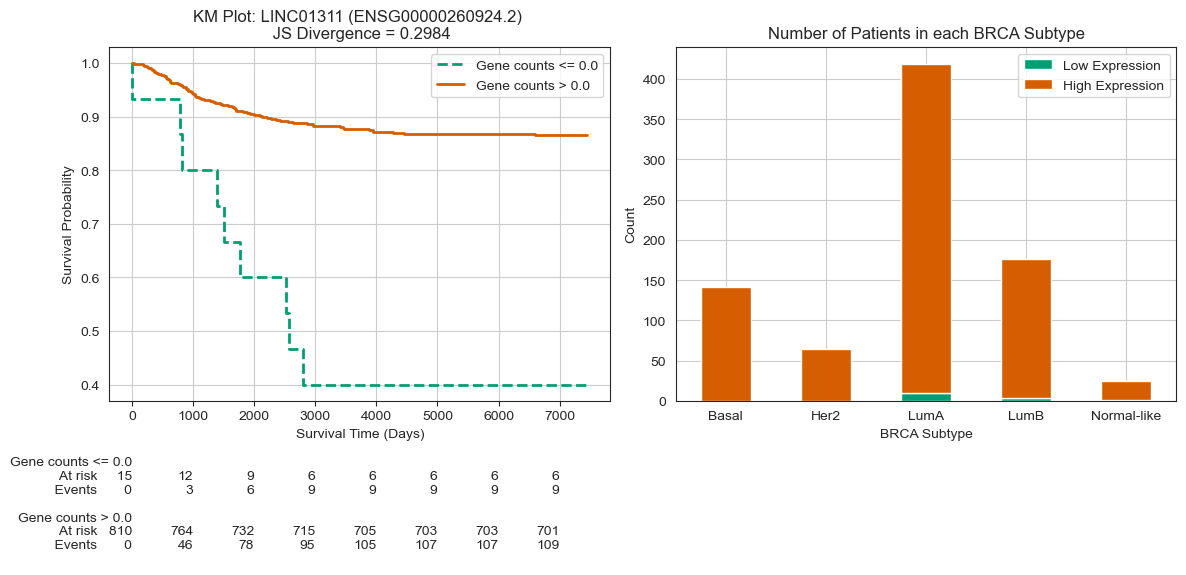

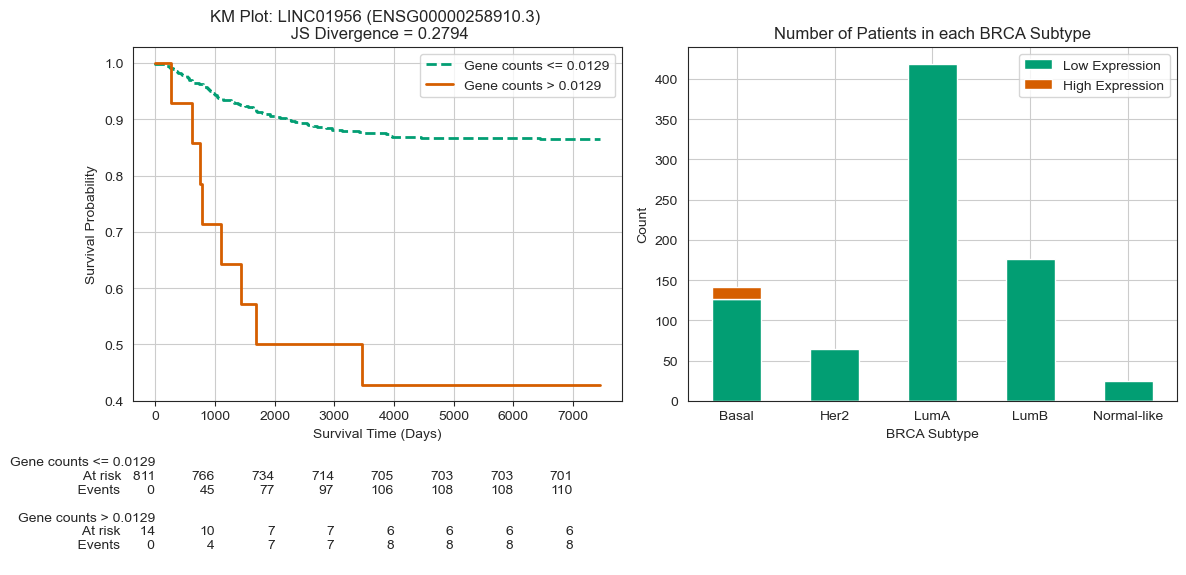

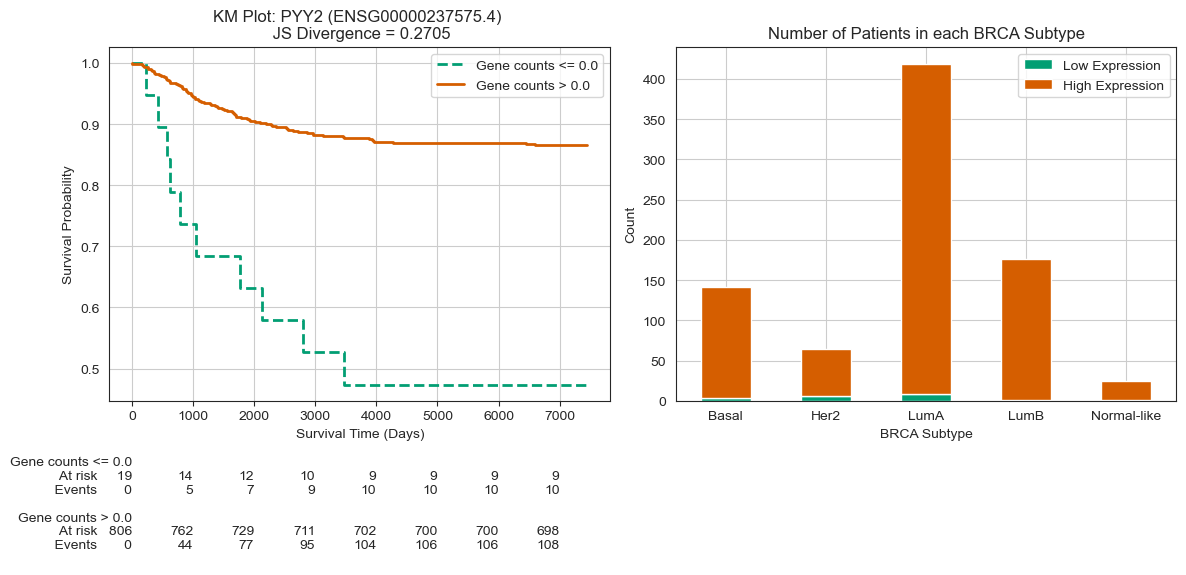

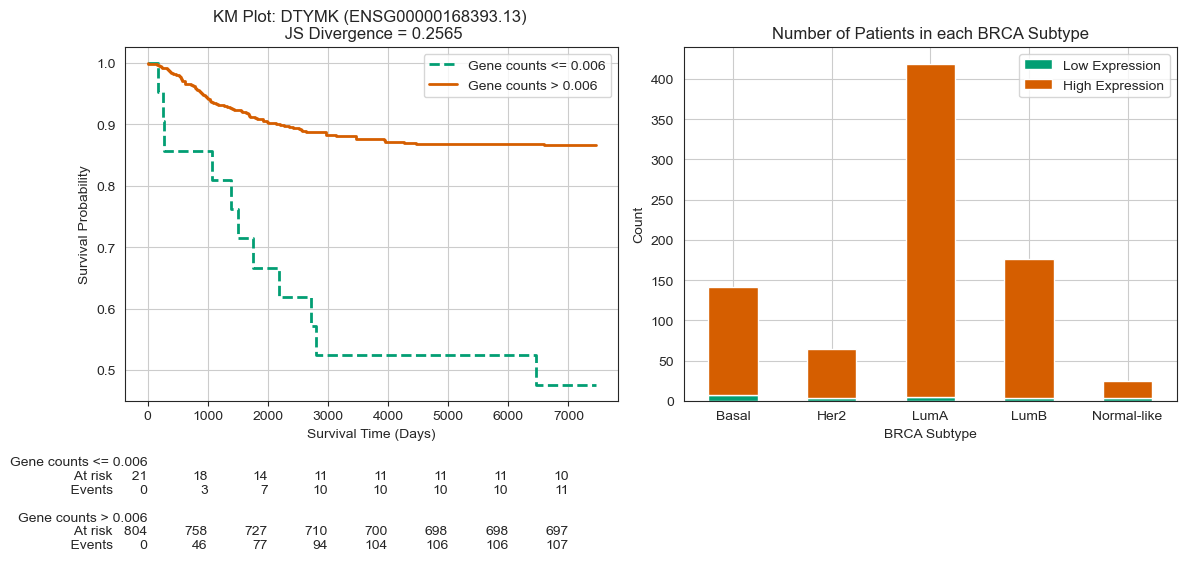

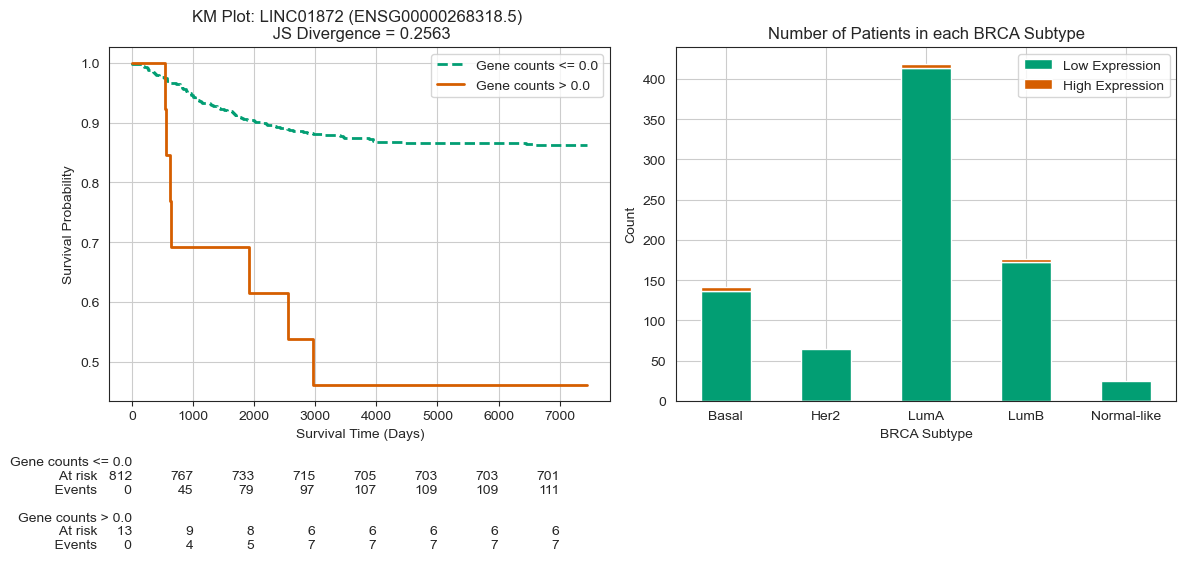

In [395]:
for i, gene in enumerate(gene_list_All[:5]):
    # Get gene count of that gene
    row = pd.to_numeric(df_with_subtype.loc[gene].values, errors='coerce')

    # Get optimal threshold for that gene
    tbl = filtered_df[filtered_df['gene'] == gene]
    optimal_threshold = pd.to_numeric(tbl['threshold'].values[0], errors='coerce')

    # Extract days to death
    time_g1 = survival_time[row <= optimal_threshold]
    time_g2 = survival_time[row > optimal_threshold]
    
    # Extract status
    status_g1 = status[row <= optimal_threshold]
    status_g2 = status[row > optimal_threshold]

    # Extract KS_statistics
    jsd = round(tbl['JSD'].values[0], 4)
    text = f"JS Divergence = {jsd}"

    # Fit KaplanMeierFitter
    kmf_1 = KaplanMeierFitter()
    kmf_2 = KaplanMeierFitter()
    kmf_1.fit(time_g1, status_g1, label=f"Gene counts <= {round(optimal_threshold, 4)}")
    kmf_2.fit(time_g2, status_g2, label=f"Gene counts > {round(optimal_threshold, 4)}")

    # Plot Kaplan-Meier survival functions
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Top subplot
    ax = axs[0]
    kmf_1.plot_survival_function(ax=ax, ci_show=False, linestyle='dashed', linewidth=2, color=sns.color_palette('colorblind')[2])
    kmf_2.plot_survival_function(ax=ax, ci_show=False, linestyle='solid', linewidth=2, color=sns.color_palette('colorblind')[3])
    add_at_risk_counts(kmf_1, kmf_2, ax=ax, rows_to_show=['At risk', 'Events'])

    ax.set_title(f"KM Plot: {gene_id_to_name.get(gene, gene)} ({gene}) \n {text}")
    ax.set_xlabel("Survival Time (Days)")
    ax.set_ylabel("Survival Probability")
    ax.grid(True)
    ax.legend()
    
    # Plot number of samples in each subtype
    # Extract subtypes
    type_g1 = subtypes[row <= optimal_threshold]
    type_g2 = subtypes[row > optimal_threshold]

    # Count occurrences of each unique type
    unique_values = np.unique(np.concatenate([type_g1, type_g2]))

    # Count occurrences for each unique value in type_g1 and type_g2
    counts_type1 = np.array([np.count_nonzero(type_g1 == val) for val in unique_values])
    counts_type2 = np.array([np.count_nonzero(type_g2 == val) for val in unique_values])

    # Create a DataFrame directly
    df = pd.DataFrame({
        'Count': unique_values,
        'Low Expression': counts_type1,
        'High Expression': counts_type2
    }).set_index('Count')

    # Bottom subplot
    ax = axs[1]
    df.plot(kind='bar', stacked=True, color=[palette[2], palette[3]], ax=ax)
    ax.set_xlabel('BRCA Subtype')
    ax.set_xticklabels(df.index, rotation=0)
    ax.set_ylabel('Count')
    ax.set_title('Number of Patients in each BRCA Subtype')
    ax.grid()
    plt.tight_layout()
    plt.show()

In [ ]:
boxplot_data = []
for gene in gene_list_All[:1]:
    # Get gene count
    row = pd.to_numeric(df_with_subtype.loc[gene].values, errors='coerce')
    # Get optimal threshold for that gene
    tbl = jsd_result[jsd_result['gene'] == gene]
    optimal_threshold = pd.to_numeric(tbl['threshold'].values[0], errors='coerce')
    
    # Split time, status based on current threshold
    time_g1 = survival_time[row <= optimal_threshold]
    time_g2 = survival_time[row > optimal_threshold]

    # Append the gene, means, and group sizes as a list to result
    boxplot_data.append([gene_id_to_name.get(gene, gene), list(time_g1), list(time_g2)])

# Convert result into a DataFrame
boxplot_data = pd.DataFrame(boxplot_data, columns=['gene', 'time_le', 'time_he'])

# Convert the lists from 'time_le' and 'time_he' columns into a long format DataFrame
df_long = pd.DataFrame({
    'gene': boxplot_data['gene'].repeat(boxplot_data['time_le'].apply(len) + boxplot_data['time_he'].apply(len)),
    'time': sum(boxplot_data['time_le'].tolist(), []) + sum(boxplot_data['time_he'].tolist(), []),
    'group': ['Low Expression'] * sum(boxplot_data['time_le'].apply(len)) + ['High Expression'] * sum(boxplot_data['time_he'].apply(len))
})

plt.figure(figsize=(6, 6))
# Create the violin plot
sns.violinplot(x='gene', y='time', hue='group', data=df_long,
               palette={'Low Expression': palette[2], 'High Expression': palette[3]},
               split=True, inner='quartile', linewidth=1.2)
plt.title('Survival Time Distribution')
plt.xlabel('')
plt.ylabel('Survival Time (days)')
plt.legend(title='Group', loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Imbalanced group

In [128]:
# Filter result with 1 person in a group
x = 823
imbalanced_df = jsd_result[abs(jsd_result['size_le'] - jsd_result['size_he']) == x]
imbalanced_df

,gene,threshold,JSD,size_le,size_he
13732,ENSG00000174677.4,0.000216,0.693147,824.0,1.0
7582,ENSG00000138002.16,0.001338,0.693147,1.0,824.0
13045,ENSG00000171425.10,0.080145,0.693147,824.0,1.0
13046,ENSG00000171428.15,1.280169,0.693147,824.0,1.0
43049,ENSG00000255769.7,0.000000,0.693147,1.0,824.0
...,...,...,...,...,...
55573,ENSG00000279528.1,0.000000,0.052394,824.0,1.0
26086,ENSG00000225508.1,0.000000,0.052394,824.0,1.0
49617,ENSG00000267792.1,0.000000,0.052394,824.0,1.0
20956,ENSG00000207289.1,0.000000,0.052394,824.0,1.0


In [129]:
imbalanced_list = imbalanced_df.iloc[:, 0].to_list()
sample_id = df_with_subtype.columns

In [131]:
samples_dict = {}
for i, gene in enumerate(imbalanced_list):
    # Get gene count of that gene
    row = pd.to_numeric(df_with_subtype.loc[gene].values, errors='coerce')

    # Get optimal threshold for that gene
    tbl = imbalanced_df[imbalanced_df['gene'] == gene]
    optimal_threshold = pd.to_numeric(tbl['threshold'].values[0], errors='coerce')

    # Split samples based on the optimal threshold
    sample_g1 = sample_id[row <= optimal_threshold]
    sample_g2 = sample_id[row > optimal_threshold]

    # Store either sample_g1 or sample_g2 in the dictionary
    if len(sample_g1) == 1:
        samples_dict[gene] = sample_g1[0]  # Store the single sample from sample_g1
    elif len(sample_g2) == 1:
        samples_dict[gene] = sample_g2[0]  # Store the single sample from sample_g2

# Print the length of the dictionary
print(len(samples_dict))

10082


In [132]:
sample_list = list(samples_dict.values())
sample_list = pd.Series(sample_list)
counts = sample_list.value_counts()
counts

TCGA-A7-A13E-01B    3259
TCGA-AC-A2QJ-01A    1665
TCGA-BH-A1FM-01A     520
TCGA-A2-A0T2-01A     382
TCGA-A1-A0SK-01A     352
                    ... 
TCGA-A7-A4SF-01A       1
TCGA-A8-A096-01A       1
TCGA-A8-A09I-01A       1
TCGA-A2-A3KD-01A       1
TCGA-AR-A24R-01A       1
Name: count, Length: 294, dtype: int64

In [133]:
# Read survival time data
clinical = pd.read_csv('/Users/tk/Desktop/Research-CITS5014/GDC_Data/clinical.project-tcga-brca.2024-03-19/clinical.tsv', delimiter='\t')

# Each case_submitter_id has 2 records
clinical = clinical.drop_duplicates(subset='case_submitter_id')
clinical.head()

,case_id,case_submitter_id,project_id,age_at_index,age_is_obfuscated,cause_of_death,cause_of_death_source,country_of_residence_at_enrollment,days_to_birth,days_to_death,...,treatment_arm,treatment_dose,treatment_dose_units,treatment_effect,treatment_effect_indicator,treatment_frequency,treatment_intent_type,treatment_or_therapy,treatment_outcome,treatment_type
0,001cef41-ff86-4d3f-a140-a647ac4b10a1,TCGA-E2-A1IU,TCGA-BRCA,60,'--,'--,'--,'--,-22279,'--,...,'--,'--,'--,'--,'--,'--,'--,no,'--,"Radiation Therapy, NOS"
2,0045349c-69d9-4306-a403-c9c1fa836644,TCGA-A1-A0SB,TCGA-BRCA,70,'--,'--,'--,'--,-25833,'--,...,'--,'--,'--,'--,'--,'--,'--,not reported,'--,"Radiation Therapy, NOS"
4,00807dae-9f4a-4fd1-aac2-82eb11bf2afb,TCGA-A2-A04W,TCGA-BRCA,50,'--,'--,'--,'--,-18345,'--,...,'--,'--,'--,'--,'--,'--,'--,no,'--,"Radiation Therapy, NOS"
6,00a2d166-78c9-4687-a195-3d6315c27574,TCGA-AN-A0AM,TCGA-BRCA,56,'--,'--,'--,'--,-20713,'--,...,'--,'--,'--,'--,'--,'--,'--,no,'--,"Pharmaceutical Therapy, NOS"
8,00b11ca8-8540-4a3d-b602-ec754b00230b,TCGA-LL-A440,TCGA-BRCA,61,'--,'--,'--,'--,-22497,'--,...,'--,'--,'--,'--,'--,'--,'--,yes,'--,"Pharmaceutical Therapy, NOS"


In [134]:
# Remove '-01A' from each element in the list
case_submitter_id_list = [item.replace('-01A', '') for item in sample_list]
imbalanced_clinical = clinical[clinical['case_submitter_id'].isin(case_submitter_id_list)]
imbalanced_clinical

,case_id,case_submitter_id,project_id,age_at_index,age_is_obfuscated,cause_of_death,cause_of_death_source,country_of_residence_at_enrollment,days_to_birth,days_to_death,...,treatment_arm,treatment_dose,treatment_dose_units,treatment_effect,treatment_effect_indicator,treatment_frequency,treatment_intent_type,treatment_or_therapy,treatment_outcome,treatment_type
12,01263518-5f7c-49dc-8d7e-84b0c03a6a63,TCGA-A8-A07W,TCGA-BRCA,76,'--,'--,'--,'--,-27942,'--,...,'--,'--,'--,'--,'--,'--,'--,no,'--,"Radiation Therapy, NOS"
16,01674b2c-5cf2-478f-84a1-f69c39f47bd4,TCGA-EW-A1P7,TCGA-BRCA,59,'--,'--,'--,'--,-21750,'--,...,'--,'--,'--,'--,'--,'--,'--,yes,'--,"Pharmaceutical Therapy, NOS"
28,02bbb632-0f7f-439d-b8f0-c86a06237424,TCGA-AC-A2FB,TCGA-BRCA,65,'--,'--,'--,'--,-23851,'--,...,'--,'--,'--,'--,'--,'--,'--,yes,'--,"Pharmaceutical Therapy, NOS"
34,02e6f999-24f2-4ad2-9b92-df3ee2b082e5,TCGA-D8-A1JC,TCGA-BRCA,59,'--,'--,'--,'--,-21898,'--,...,'--,'--,'--,'--,'--,'--,'--,yes,'--,"Pharmaceutical Therapy, NOS"
36,02f5ae33-a563-4ecb-9e33-dfa500a44931,TCGA-A8-A093,TCGA-BRCA,61,'--,'--,'--,'--,-22373,'--,...,'--,'--,'--,'--,'--,'--,'--,yes,'--,"Radiation Therapy, NOS"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2143,f6eebd4b-b63a-4a9c-92d3-0d954a8a6655,TCGA-AC-A2FE,TCGA-BRCA,62,'--,'--,'--,'--,-22746,2636,...,'--,'--,'--,'--,'--,'--,'--,yes,'--,"Pharmaceutical Therapy, NOS"
2155,f83b866b-0b2e-4bba-9367-be6dccf56232,TCGA-E2-A2P6,TCGA-BRCA,77,'--,'--,'--,'--,-28411,'--,...,'--,'--,'--,'--,'--,'--,'--,no,'--,"Radiation Therapy, NOS"
2163,f9eb88f7-9293-46bf-ace4-a746e4ff80dc,TCGA-A8-A086,TCGA-BRCA,59,'--,'--,'--,'--,-21731,'--,...,'--,'--,'--,'--,'--,'--,'--,yes,'--,"Pharmaceutical Therapy, NOS"
2169,fac173a8-1613-4bd4-87ba-83a2cfe8a37d,TCGA-AC-A3EH,TCGA-BRCA,79,'--,'--,'--,'--,-29014,197,...,'--,'--,'--,'--,'--,'--,'--,no,'--,"Radiation Therapy, NOS"


### Intersection

In [396]:
# Read JSD results
list_of_mins = ['01', '10', '20', '30', '40', '50']
top_genes = {}
df_dict = {}

for min_value in list_of_mins:
    jsd_result = pd.read_csv(f'./result2/ot_all_kl_{min_value}.csv', sep=',')
    jsd_result = jsd_result[jsd_result['JSD'] != -np.inf].sort_values(by='JSD', ascending=False)
    jsd_result = jsd_result[jsd_result['JSD'] >= 0.2]    
    
    # Store the DataFrame
    df_dict[f'jsd_{min_value}'] = jsd_result
    # Extract top genes and convert to set
    top_genes[f'top_gene_jsd_{min_value}'] = set(jsd_result.iloc[:, 0])
    
    print(f"Number of top genes in jsd_result_{min_value}: {len(top_genes[f'top_gene_jsd_{min_value}'])}")

    # Find the maximum JSD
    max_value = jsd_result['JSD'].max()
    print(f"Max value of JSD in jsd_result_{min_value}: {max_value:.4f}")

Number of top genes in jsd_result_01: 2222
Max value of JSD in jsd_result_01: 0.4180
Number of top genes in jsd_result_10: 0
Max value of JSD in jsd_result_10: nan
Number of top genes in jsd_result_20: 0
Max value of JSD in jsd_result_20: nan
Number of top genes in jsd_result_30: 0
Max value of JSD in jsd_result_30: nan
Number of top genes in jsd_result_40: 0
Max value of JSD in jsd_result_40: nan
Number of top genes in jsd_result_50: 0
Max value of JSD in jsd_result_50: nan


<Figure size 1000x800 with 0 Axes>

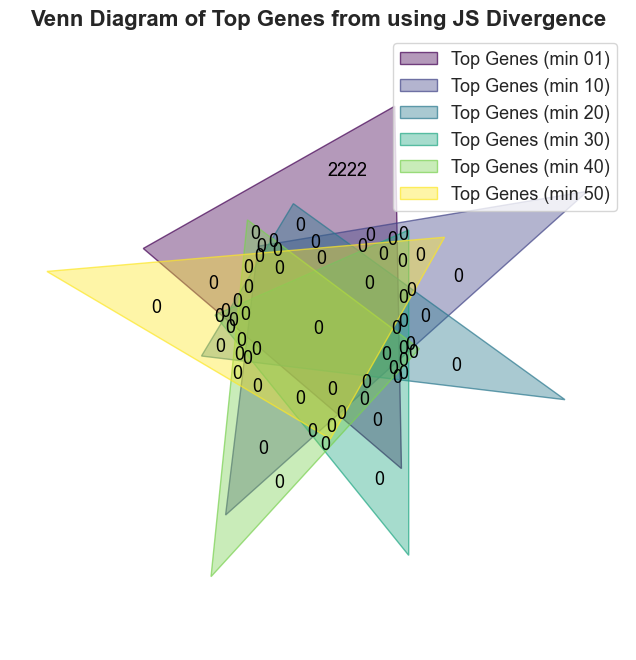

In [397]:
# Prepare data for the Venn diagram
venn_data = {f'Top Genes (min {min_value})': top_genes[f'top_gene_jsd_{min_value}'] for min_value in list_of_mins}
plt.figure(figsize=(10, 8))
venn(venn_data)
plt.title('Venn Diagram of Top Genes from using JS Divergence', fontsize=16, fontweight='bold')
plt.show()

In [369]:
# Compute the intersection of all sets
sets = top_genes.values()
if sets:  # Check if there are any sets to intersect
    intersection = set.intersection(*sets)
    print("Number of intersection top genes:", len(intersection))
    intersection_list = list(intersection)
    comparison_df = pd.DataFrame(index=intersection_list, columns=list_of_mins)
    
    # Store optimal threshold for each top gene
    for gene in intersection_list:
        for min_value in list_of_mins:
            jsd_result = df_dict[f'jsd_{min_value}']
            gene_row = jsd_result[jsd_result.iloc[:, 0] == gene]
            if not gene_row.empty:
                comparison_df.loc[gene, min_value] = gene_row.iloc[0, 2]  # Compare JSD column

    # Calculate statistics
    comparison_df = comparison_df.apply(pd.to_numeric)
    comparison_df['Std Dev'] = comparison_df.std(axis=1)

Number of intersection top genes: 0


In [370]:
comparison_df

,01,10,20,30,40,50,Std Dev


In [371]:
intersection_list = comparison_df.index
for gene in intersection_list:
    print(gene_id_to_name.get(gene, gene))

In [372]:
# Select min group size threshold = 10% as a final result
jsd_result = pd.read_csv(f'./result2/ot_all_kl_10.csv', sep=',')
jsd_result = jsd_result[jsd_result['JSD'] != -np.inf].sort_values(by='JSD', ascending=False)
jsd_result

,gene,threshold,JSD,size_le,size_he
11968,ENSG00000166902.5,0.011047,0.164904,84.0,741.0
8816,ENSG00000146232.17,0.006219,0.161880,83.0,742.0
15827,ENSG00000184887.13,0.015876,0.158136,84.0,741.0
2351,ENSG00000100599.16,0.005581,0.157281,83.0,742.0
1839,ENSG00000089356.18,0.000234,0.157281,83.0,742.0
...,...,...,...,...,...
27871,ENSG00000228131.1,0.000006,0.071226,734.0,91.0
60332,ENSG00000287946.1,0.000005,0.071044,728.0,97.0
59194,ENSG00000286784.1,0.000005,0.069014,741.0,84.0
21575,ENSG00000211739.4,0.000000,0.068194,742.0,83.0


In [373]:
filtered_df = jsd_result[jsd_result['gene'].isin(intersection_list)]
filtered_df

,gene,threshold,JSD,size_le,size_he


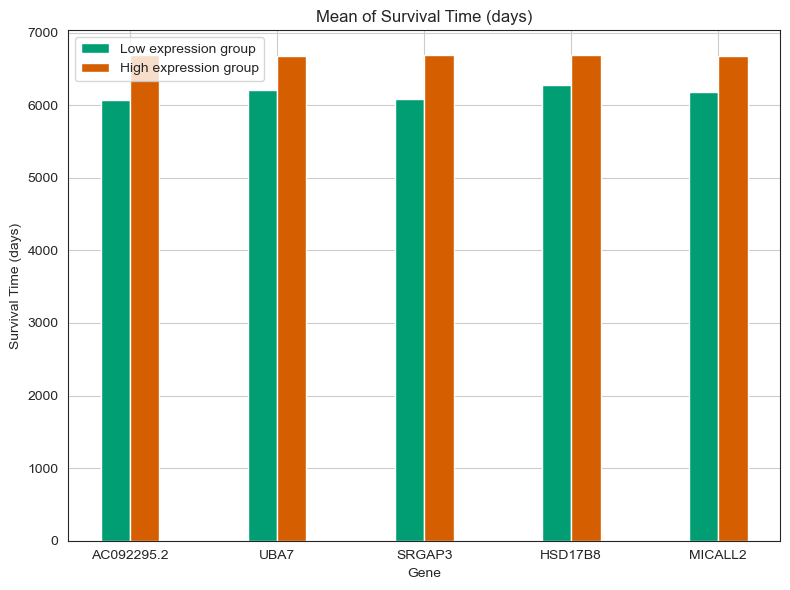

In [179]:
norm_count = pd.read_csv('./norm_PAM50.csv', low_memory=False)
norm_count.set_index(norm_count.columns[0], inplace=True)

# Get survival time, status, and subtype from the dataframe
survival_time = pd.to_numeric(norm_count.iloc[-3].values, errors='coerce')
status = pd.to_numeric(norm_count.iloc[-2].values, errors='coerce')
subtypes = norm_count.iloc[-1].values

mean_time = []
for gene in intersection_list[:5]:
    # Get gene count
    row = pd.to_numeric(norm_count.loc[gene].values, errors='coerce')
    # Get optimal threshold for that gene
    tbl = jsd_result[jsd_result['gene'] == gene]
    optimal_threshold = pd.to_numeric(tbl['threshold'].values[0], errors='coerce') 
    # Split time, status based on current threshold
    time_g1 = survival_time[row <= optimal_threshold]
    time_g2 = survival_time[row > optimal_threshold]
    size_le = len(time_g1)
    size_he = len(time_g2)
    mean_t1 = time_g1.mean()
    mean_t2 = time_g2.mean()
    # Append the gene, means, and group sizes as a list to result
    mean_time.append([gene_id_to_name.get(gene, gene), mean_t1, mean_t2, size_le, size_he])

# Convert result into a DataFrame
mean_time = pd.DataFrame(mean_time, columns=['gene', 'mean_time_le', 'mean_time_he', 'size_le', 'size_he'])

fig, ax = plt.subplots(figsize=(8, 6))
palette = sns.color_palette('colorblind', 6)

# Set the positions and width for the bars
bar_width = 0.2
index = range(len(mean_time))

# Plot bars for Mean_Time_G1
bars1 = ax.bar(index, mean_time['mean_time_le'], bar_width, label='Low expression group', color=palette[2])
# Plot bars for Mean_Time_G2
bars2 = ax.bar([i + bar_width for i in index], mean_time['mean_time_he'], bar_width, label='High expression group', color=palette[3])
ax.set_xlabel('Gene')
ax.set_ylabel('Survival Time (days)')
ax.set_title('Mean of Survival Time (days)')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(mean_time['gene'], rotation=0)
ax.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

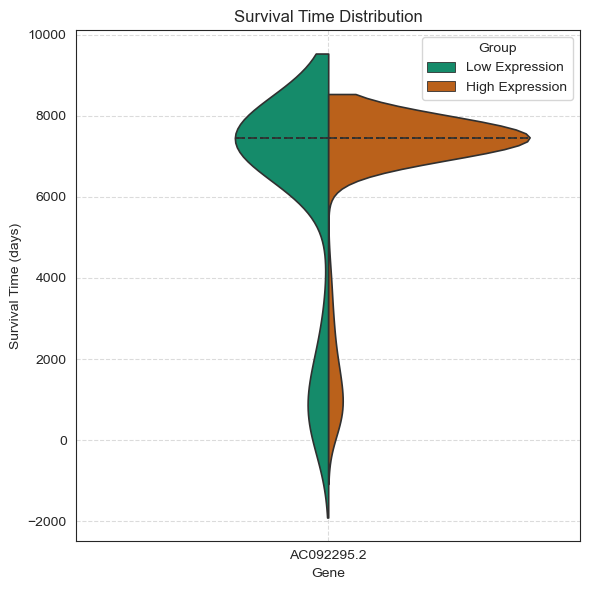

In [181]:
boxplot_data = []
for gene in intersection_list[:1]:
    # Get gene count
    row = pd.to_numeric(norm_count.loc[gene].values, errors='coerce')
    # Get optimal threshold for that gene
    tbl = jsd_result[jsd_result['gene'] == gene]
    optimal_threshold = pd.to_numeric(tbl['threshold'].values[0], errors='coerce')
    
    # Split time, status based on current threshold
    time_g1 = survival_time[row <= optimal_threshold]
    time_g2 = survival_time[row > optimal_threshold]

    # Append the gene, means, and group sizes as a list to result
    boxplot_data.append([gene_id_to_name.get(gene, gene), list(time_g1), list(time_g2)])

# Convert result into a DataFrame
boxplot_data = pd.DataFrame(boxplot_data, columns=['gene', 'time_le', 'time_he'])

# Convert the lists from 'time_le' and 'time_he' columns into a long format DataFrame
df_long = pd.DataFrame({
    'gene': boxplot_data['gene'].repeat(boxplot_data['time_le'].apply(len) + boxplot_data['time_he'].apply(len)),
    'time': sum(boxplot_data['time_le'].tolist(), []) + sum(boxplot_data['time_he'].tolist(), []),
    'group': ['Low Expression'] * sum(boxplot_data['time_le'].apply(len)) + ['High Expression'] * sum(boxplot_data['time_he'].apply(len))
})

plt.figure(figsize=(6, 6))
# Create the violin plot
sns.violinplot(x='gene', y='time', hue='group', data=df_long,
               palette={'Low Expression': palette[2], 'High Expression': palette[3]},
               split=True, inner='quartile', linewidth=1.2)
plt.title('Survival Time Distribution')
plt.xlabel('Gene')
plt.ylabel('Survival Time (days)')
plt.legend(title='Group', loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

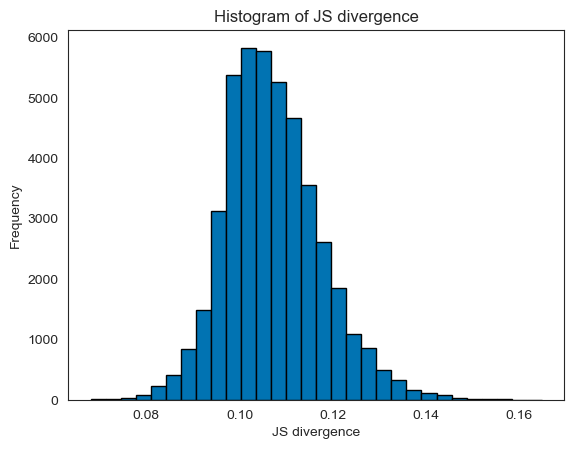

In [182]:
plt.hist(jsd_result['JSD'], bins=30, edgecolor='black')
plt.title('Histogram of JS divergence')
plt.xlabel('JS divergence')
plt.ylabel('Frequency')
plt.show()

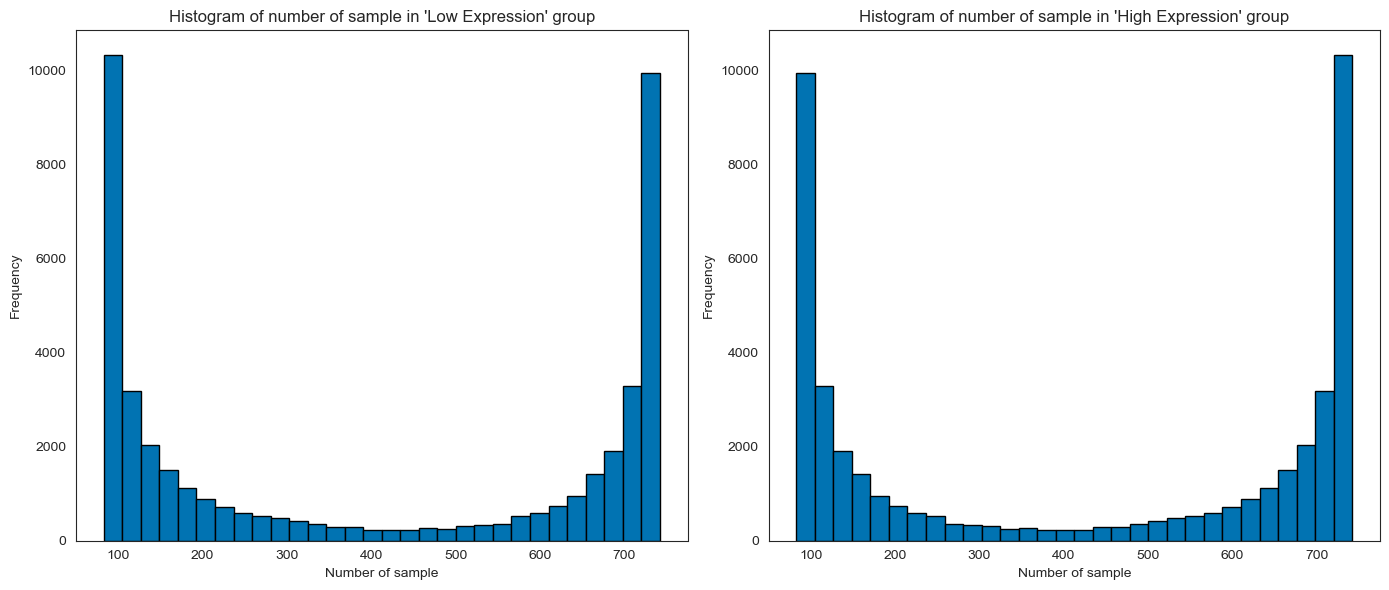

In [183]:
# Plot sample group size
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].hist(jsd_result['size_le'], bins=30, edgecolor='black')
ax[0].set_xlabel('Number of sample')
ax[0].set_ylabel('Frequency')
ax[0].set_title("Histogram of number of sample in 'Low Expression' group")
ax[1].hist(jsd_result['size_he'], bins=30, edgecolor='black')
ax[1].set_xlabel('Number of sample')
ax[1].set_ylabel('Frequency')
ax[1].set_title("Histogram of number of sample in 'High Expression' group")
plt.tight_layout()
plt.show()

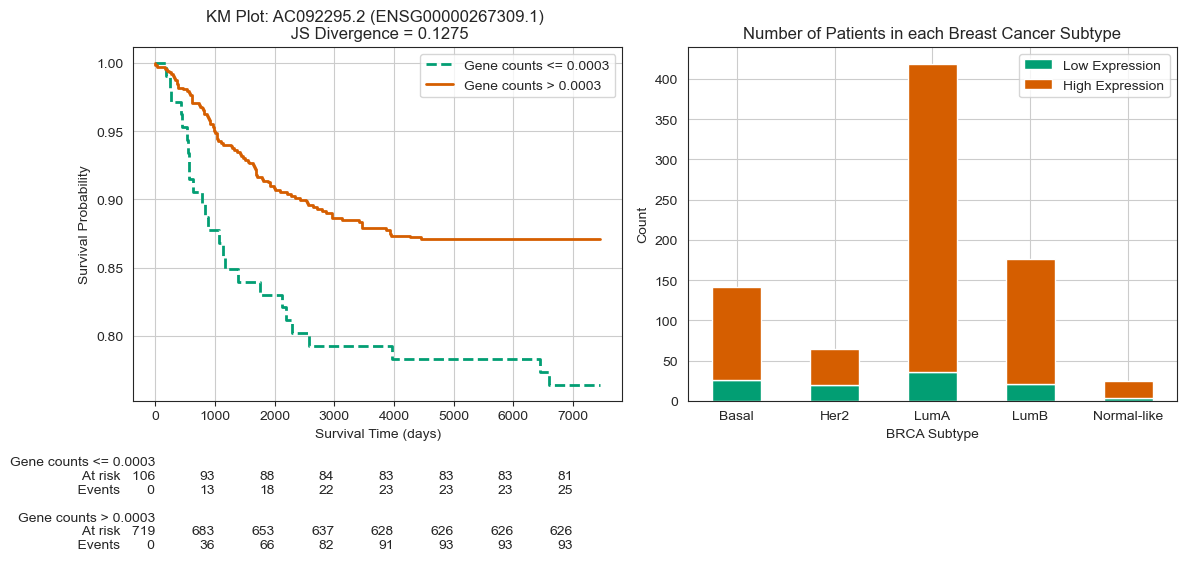

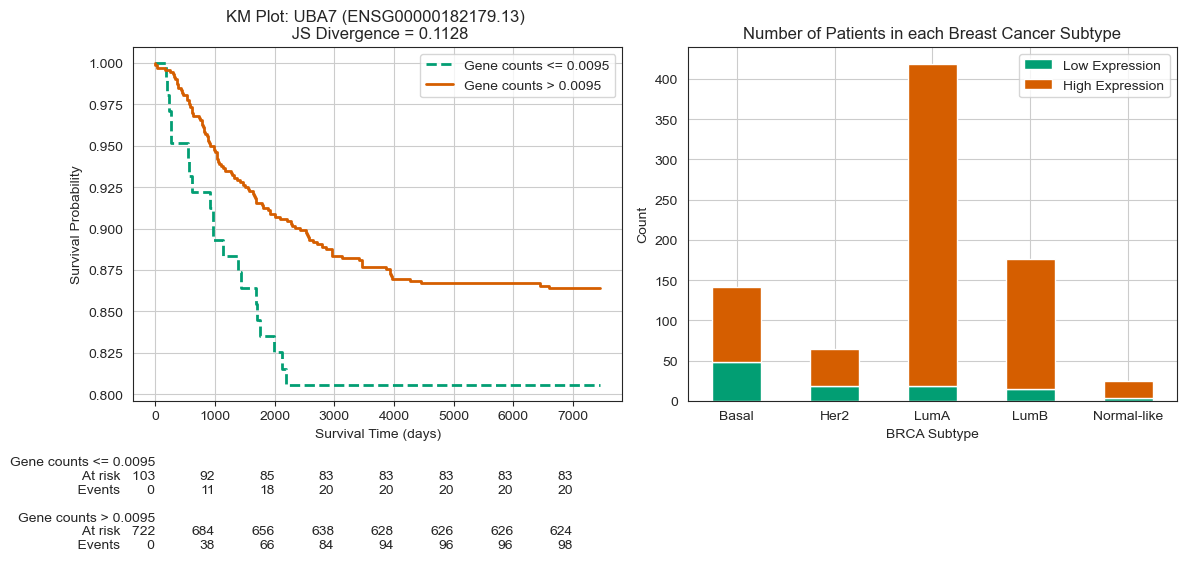

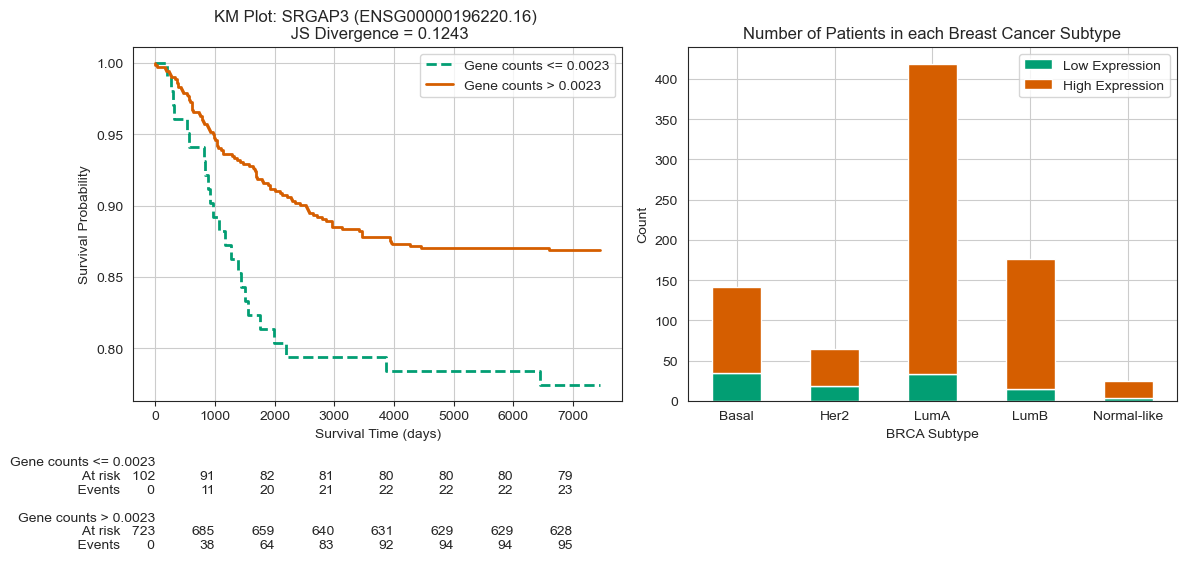

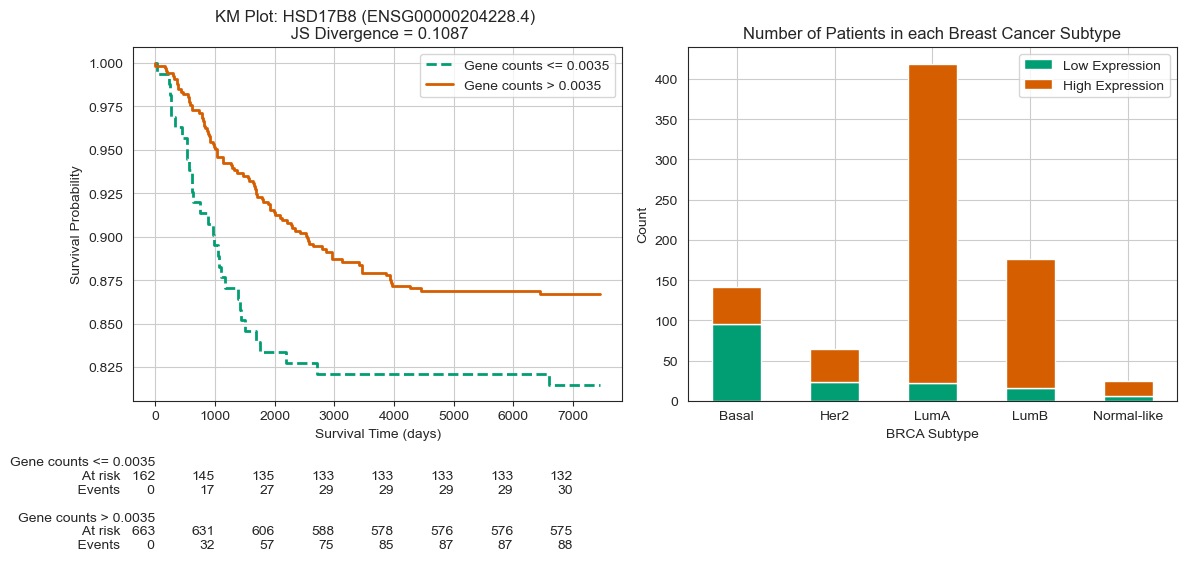

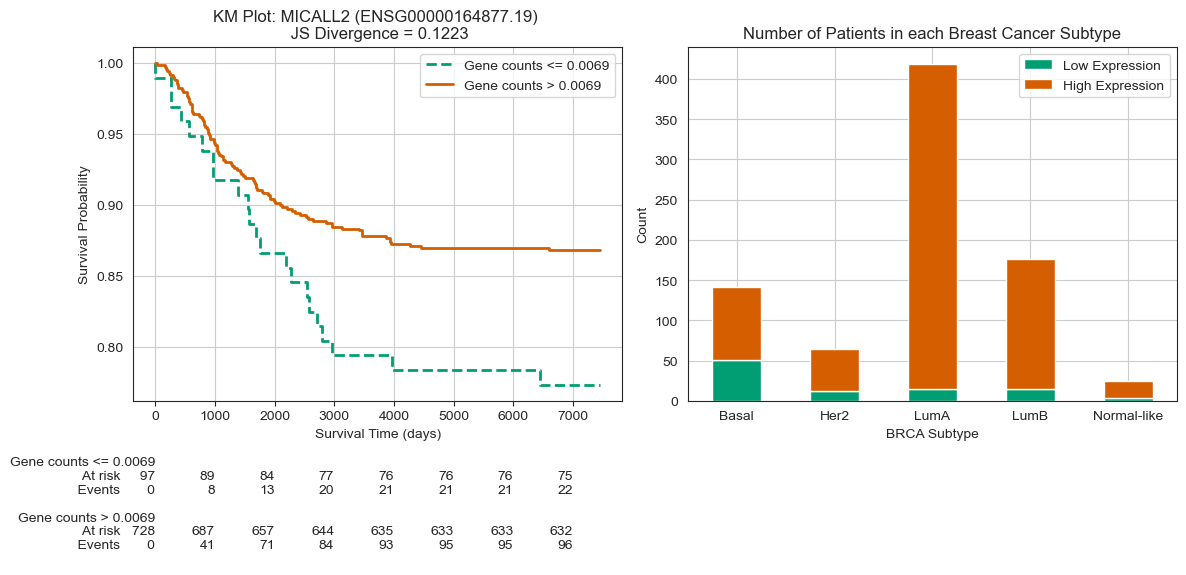

In [185]:
# Plot KM Curves
for i, gene in enumerate(intersection_list[:5]):

    # Get gene count of that gene
    row = pd.to_numeric(df_with_subtype.loc[gene].values, errors='coerce')
    # Find the median value
    # optimal_threshold = np.median(row)
    # print(median_value)

    # Get optimal threshold for that gene
    tbl = jsd_result[jsd_result['gene'] == gene]
    optimal_threshold = pd.to_numeric(tbl['threshold'].values[0], errors='coerce')

    # Extract days to death
    time_g1 = survival_time[row <= optimal_threshold]
    time_g2 = survival_time[row > optimal_threshold]
    
    # Extract status
    status_g1 = status[row <= optimal_threshold]
    status_g2 = status[row > optimal_threshold]

    data_g1 = pd.DataFrame({
        'survival_time': time_g1,
        'event_occurred': status_g1})

    data_g2 = pd.DataFrame({
    'survival_time': time_g2,
    'event_occurred': status_g2})

    # Extract JSD
    jsd = round(tbl['JSD'].values[0], 4)
    text = f"JS Divergence = {jsd}"

    # Fit KaplanMeierFitter
    kmf_1 = KaplanMeierFitter()
    kmf_2 = KaplanMeierFitter()
    kmf_1.fit(data_g1['survival_time'], data_g1['event_occurred'], label=f"Gene counts <= {round(optimal_threshold, 4)}")
    kmf_2.fit(data_g2['survival_time'], data_g2['event_occurred'], label=f"Gene counts > {round(optimal_threshold, 4)}")

    # Plot Kaplan-Meier survival functions
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Top subplot
    ax = axs[0]
    kmf_1.plot_survival_function(ax=ax, ci_show=False, linestyle='dashed', linewidth=2, color=sns.color_palette('colorblind')[2])
    kmf_2.plot_survival_function(ax=ax, ci_show=False, linestyle='solid', linewidth=2, color=sns.color_palette('colorblind')[3])
    add_at_risk_counts(kmf_1, kmf_2, ax=ax, rows_to_show=['At risk', 'Events'])

    ax.set_title(f"KM Plot: {gene_id_to_name.get(gene, gene)} ({gene}) \n {text}")
    ax.set_xlabel("Survival Time (days)")
    ax.set_ylabel("Survival Probability")
    ax.grid(True)
    ax.legend()
    
    ###########
    # Extract subtypes
    type_g1 = subtypes[row <= optimal_threshold]
    type_g2 = subtypes[row > optimal_threshold]

    # Count occurrences of each unique type
    unique_values = np.unique(np.concatenate([type_g1, type_g2]))

    # Count occurrences for each unique value in result1 and result2
    counts_result1 = np.array([np.count_nonzero(type_g1 == val) for val in unique_values])
    counts_result2 = np.array([np.count_nonzero(type_g2 == val) for val in unique_values])

    # Create a DataFrame directly
    df = pd.DataFrame({
        'Count': unique_values,
        'Low Expression': counts_result1,
        'High Expression': counts_result2
    }).set_index('Count')

    # Normalize the DataFrame to get proportions
    df_normalized = df.div(df.sum(axis=1), axis=0)

    # Bottom subplot
    ax = axs[1]
    # df.plot(kind='barh', stacked=True, color=[palette[2], palette[3]], ax=ax)
    # df_normalized.plot(kind='bar', stacked=True, color=[palette[2], palette[3]], ax=ax)
    df.plot(kind='bar', stacked=True, color=[palette[2], palette[3]], ax=ax)
    ax.set_xlabel('BRCA Subtype')
    ax.set_xticklabels(df.index, rotation=0)
    ax.set_ylabel('Count')
    ax.set_title('Number of Patients in each Breast Cancer Subtype')
    ax.legend()
    ax.grid()
    plt.tight_layout()
    plt.show()

/Users/tk/opt/anaconda3/envs/gene/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


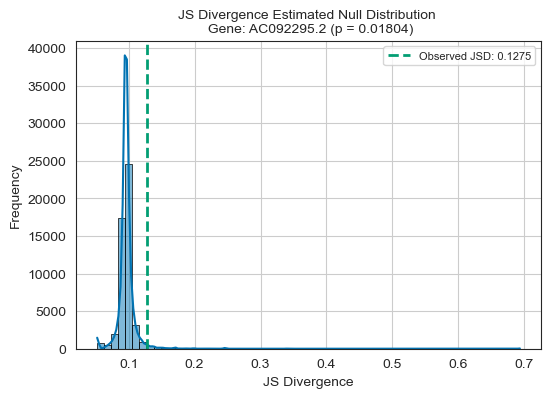

In [186]:
# Perform permutation test on the first 5 genes
num_simulation=50000
for gene in intersection_list[:1]:
    real_jsd = jsd_result.loc[jsd_result['gene'] == gene, 'JSD'].values[0]
    permutation_test(survival_time, gene, real_jsd, num_simulation)

### LumA

In [410]:
def plot_km(gene_list, result_df, subtype):
    for gene in gene_list:
        # Get gene count
        row = pd.to_numeric(norm_count.loc[gene].values, errors='coerce')

        # Get optimal threshold for that gene
        tbl = result_df[result_df['gene'] == gene]
        optimal_threshold = pd.to_numeric(tbl[f'threshold'].values[0], errors='coerce')
        jsd = pd.to_numeric(tbl[f'JSD'].values[0], errors='coerce')
        
        # Subtype masking
        mask = (subtypes == subtype)
        time = survival_time[mask]
        event = status[mask]
        count = row[mask]
        
        # Split time, status based on current threshold
        time_g1 = time[count <= optimal_threshold]
        time_g2 = time[count > optimal_threshold]
        status_g1 = event[count <= optimal_threshold]
        status_g2 = event[count > optimal_threshold]

        # Fit KaplanMeierFitter
        _, ax = plt.subplots(figsize=(6, 4))
        kmf_1 = KaplanMeierFitter()
        kmf_2 = KaplanMeierFitter()
        kmf_1.fit(time_g1, status_g1, label=f"Gene counts <= {round(optimal_threshold, 4)}")
        kmf_2.fit(time_g2, status_g2, label=f"Gene counts > {round(optimal_threshold, 4)}")

        kmf_1.plot_survival_function(ax=ax, ci_show=False, linestyle='dashed', linewidth=2, color=sns.color_palette('colorblind')[2])
        kmf_2.plot_survival_function(ax=ax, ci_show=False, linestyle='solid', linewidth=2, color=sns.color_palette('colorblind')[3])
        add_at_risk_counts(kmf_1, kmf_2, ax=ax, rows_to_show=['At risk', 'Events'])

        text = f"JSD = {jsd:.4f}"
        ax.set_title(f"KM Plot: {gene_id_to_name.get(gene, gene)} ({gene}) \n {text}")
        ax.set_xlabel("Survival Time (days)")
        ax.set_ylabel("Survival Probability")
        ax.grid()
        ax.legend();

In [411]:
def plot_distribution(list, real_val, gene, p_val, subtype):
    plt.figure(figsize=(6, 4))
    obs_color = palette[2]
    # min_color = palette[1]
    # max_color = palette[3]
    # Calculate min and max values
    # min = np.min(list)
    # max = np.max(list)
    # Plot histogram with KDE
    sns.histplot(list, bins=60, kde=True, edgecolor='black')
    plt.axvline(real_val, color=obs_color, linestyle='--', label=f'Observed KS statistic: {real_val:.4f}', linewidth=2) 
    # plt.axvline(min, color=min_color, linestyle='--', label=f'Min simulated KS statistic: {min:.4f}', linewidth=2)
    # plt.axvline(max, color=max_color, linestyle='--', label=f'Max simulated KS statistic: {max:.4f}', linewidth=2) 
    text = f'KS Statistic Estimated Null Distribution ({subtype}) \n Gene: {gene_id_to_name.get(gene, gene)} (p = {p_val})' 
    plt.title(f'{text}', fontsize=10)
    plt.xlabel('KS statistic')
    plt.ylabel('Frequency')
    plt.legend(fontsize=8)
    plt.grid()
    plt.show()

def bootstrap_test(survival_time, obs_stat, num_simulation, subtype):
    jsd_sim = []  
    epsilon = 1e-10
    
    for _ in range(num_simulation):
        # Subtype masking
        mask = (subtypes == subtype)
        time = survival_time[mask]

        # Select a random split index
        split_index = np.random.randint(1, len(time)//2)

        # Shuffle the data
        shuffled_data = time.copy()
        np.random.shuffle(shuffled_data)

        # Divide the data based on the split index
        group1 = shuffled_data[:split_index]
        group2 = shuffled_data[split_index:]

        # Combine both time groups to get all unique time values
        all_times = set(group1).union(set(group2))

        # Calculate the probability distribution for each group
        p = pd.Series(group1).value_counts(normalize=True).reindex(all_times, fill_value=0)
        q = pd.Series(group2).value_counts(normalize=True).reindex(all_times, fill_value=0)
        p = np.clip(p, epsilon, None)
        q = np.clip(q, epsilon, None)
      
        # Compute the average distribution
        m = 0.5 * (p + q)
        
        # Calculate KL Divergences
        KL_P_M = np.sum(p * np.log(p / m))
        KL_Q_M = np.sum(q * np.log(q / m))
        
        # Calculate JS divergence
        JSD = 0.5 * (KL_P_M + KL_Q_M)
        jsd_sim.append(JSD)
    
    # Performing a one-sided test
    extreme_count = np.sum(np.array(jsd_sim) > obs_stat)
    p_value = extreme_count / len(jsd_sim)

    # Plot simulation distribution
    # plot_distribution(ks_stats_sim, real_ks, gene, p_value.round(6), subtype)
    return jsd_sim, p_value

In [412]:
subtype = 'LumA'
jsd_result = pd.read_csv(f'./result3/jsd_{subtype}.csv', sep=',')
jsd_result = jsd_result[jsd_result['JSD'] >= 0.2].sort_values(by='JSD', ascending=False)
jsd_result

,gene,threshold,JSD,size_le,size_he
7394,ENSG00000137033.11,0.060493,0.693147,417.0,2.0
9556,ENSG00000152583.12,0.609200,0.693147,417.0,2.0
1,ENSG00000000005.6,0.008229,0.693147,418.0,1.0
17251,ENSG00000196917.6,0.227141,0.693147,418.0,1.0
16988,ENSG00000196126.11,0.024317,0.693147,1.0,418.0
...,...,...,...,...,...
8167,ENSG00000141750.7,0.000041,0.200611,12.0,407.0
33629,ENSG00000236603.2,0.000015,0.200611,12.0,407.0
31399,ENSG00000233332.1,0.000639,0.200611,407.0,12.0
21729,ENSG00000211937.3,0.000022,0.200611,12.0,407.0


In [413]:
# Filter result with balanced number of sample in each group
x = 400
filtered_df = jsd_result[abs(jsd_result['size_le'] - jsd_result['size_he']) <= x]
filtered_df

,gene,threshold,JSD,size_le,size_he
4600,ENSG00000116691.11,0.004477,0.294701,10.0,409.0
7000,ENSG00000135047.16,0.020322,0.294701,10.0,409.0
16261,ENSG00000186501.14,0.012033,0.294701,10.0,409.0
13964,ENSG00000175866.15,0.009278,0.294701,10.0,409.0
682,ENSG00000050555.19,0.000227,0.279153,12.0,407.0
...,...,...,...,...,...
8167,ENSG00000141750.7,0.000041,0.200611,12.0,407.0
33629,ENSG00000236603.2,0.000015,0.200611,12.0,407.0
31399,ENSG00000233332.1,0.000639,0.200611,407.0,12.0
21729,ENSG00000211937.3,0.000022,0.200611,12.0,407.0


In [414]:
# Get top gene lists
gene_list_LumA = filtered_df.iloc[:, 0].to_list()
len(gene_list_LumA)

135

In [403]:
# Calculate bootstrap p-value for top genes
km_df = filtered_df.copy()
num_simulation = 5000
for gene in gene_list_LumA:
    ks_obs = filtered_df.loc[filtered_df['gene'] == gene, 'JSD'].iloc[0]
    jsd_sim, p_value = bootstrap_test(survival_time, ks_obs, num_simulation, subtype)
    km_df.loc[km_df['gene'] == gene, 'bootstrap_p'] = p_value

In [404]:
# Filter result with p-value
km_df = km_df[km_df['bootstrap_p'] <= 0.001]
km_df

,gene,threshold,JSD,size_le,size_he,bootstrap_p
4600,ENSG00000116691.11,0.004477,0.294701,10.0,409.0,0.0006
7000,ENSG00000135047.16,0.020322,0.294701,10.0,409.0,0.0006
16261,ENSG00000186501.14,0.012033,0.294701,10.0,409.0,0.0004
13964,ENSG00000175866.15,0.009278,0.294701,10.0,409.0,0.0010
2026,ENSG00000095380.11,0.010669,0.264139,11.0,408.0,0.0008
721,ENSG00000054148.18,0.010400,0.264139,11.0,408.0,0.0008
5794,ENSG00000126215.14,0.002074,0.264139,11.0,408.0,0.0004
10819,ENSG00000162747.12,0.000006,0.259981,13.0,406.0,0.0004
5997,ENSG00000128254.16,0.000059,0.259981,13.0,406.0,0.0004
58605,ENSG00000286177.1,0.000299,0.258469,11.0,408.0,0.0006


In [415]:
# Get top gene lists
gene_list_LumA = km_df.iloc[:, 0].to_list()
for gene in gene_list_LumA:
    print(gene_id_to_name.get(gene, gene))

MIIP
CTSL
TMEM222
BAIAP2
NANS
PHPT1
XRCC3
FCGR3B
C22orf24
AC011462.5
ADCY1


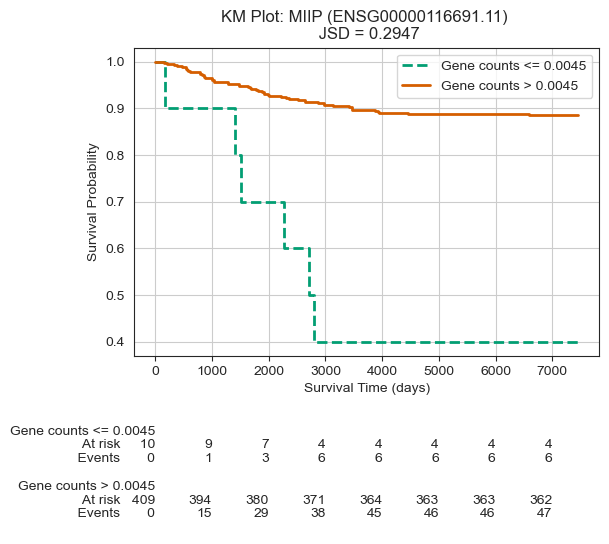

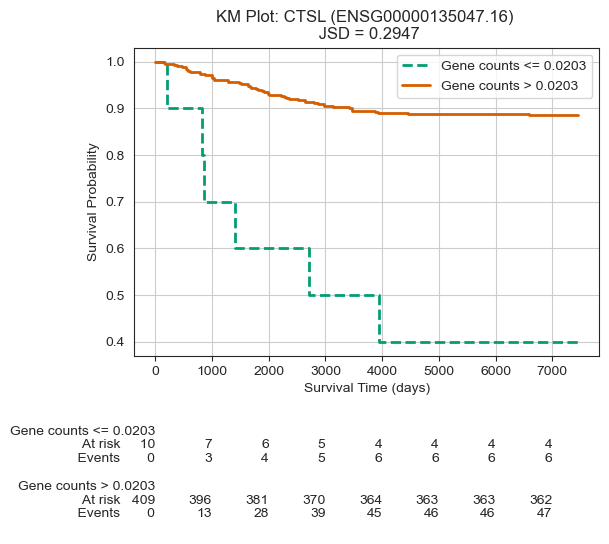

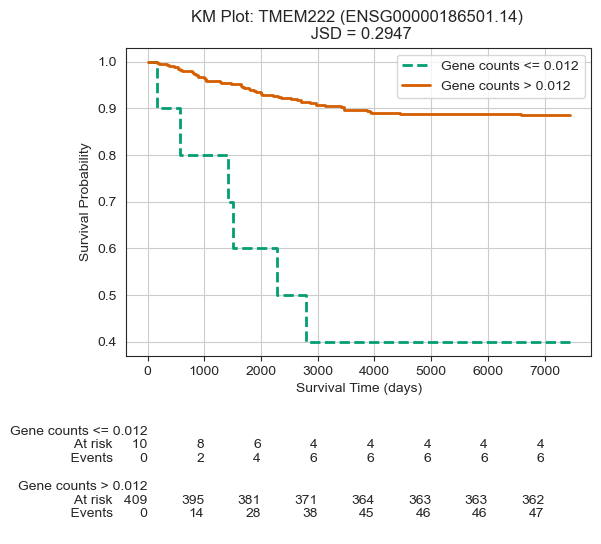

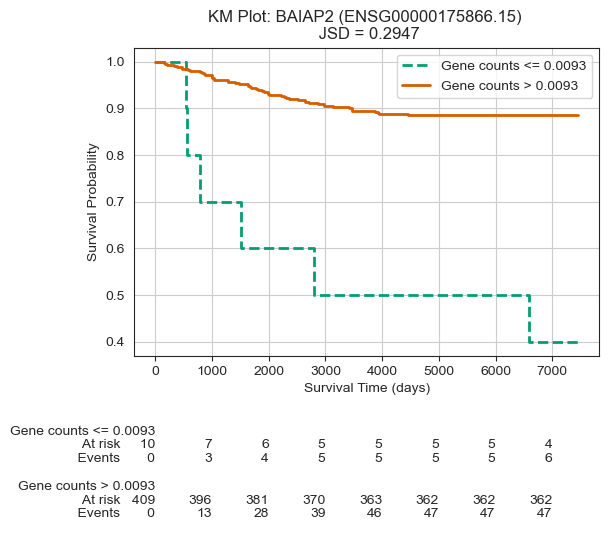

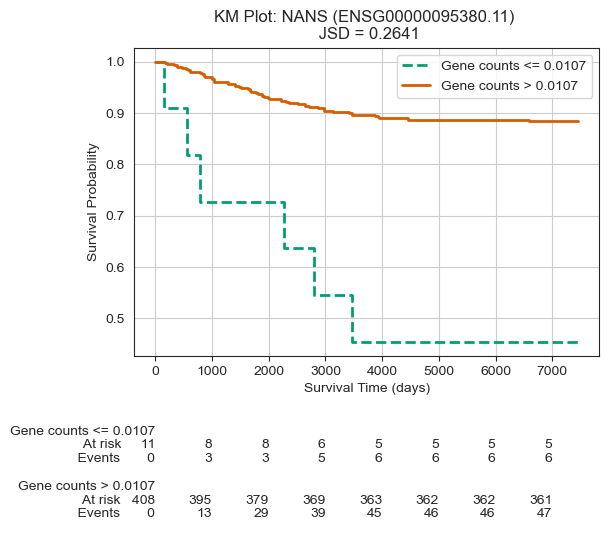

In [416]:
plot_km(gene_list_LumA[:5], filtered_df, subtype)

### LumB

In [425]:
subtype = 'LumB'
jsd_result = pd.read_csv(f'./result3/jsd_{subtype}.csv', sep=',')
jsd_result = jsd_result[jsd_result['JSD'] >= 0.2].sort_values(by='JSD', ascending=False)
jsd_result

,gene,threshold,JSD,size_le,size_he
20019,ENSG00000204842.18,0.010065,0.693147,1.0,175.0
35779,ENSG00000240997.3,0.000011,0.693147,175.0,1.0
35380,ENSG00000240014.3,0.000014,0.693147,175.0,1.0
19780,ENSG00000204219.11,0.007542,0.693147,1.0,175.0
4900,ENSG00000119414.12,0.189391,0.693147,175.0,1.0
...,...,...,...,...,...
2060,ENSG00000096384.20,0.522211,0.200372,17.0,159.0
16988,ENSG00000196126.11,0.053413,0.200372,17.0,159.0
29711,ENSG00000230825.2,0.000006,0.200372,17.0,159.0
2252,ENSG00000100298.16,0.000078,0.200372,17.0,159.0


In [426]:
# Filter result with balanced number of sample in each group
x = 160
filtered_df = jsd_result[abs(jsd_result['size_le'] - jsd_result['size_he']) <= x]
filtered_df

,gene,threshold,JSD,size_le,size_he
55788,ENSG00000279791.1,0.000007,0.395187,8.0,168.0
6431,ENSG00000131368.8,0.005161,0.395187,8.0,168.0
49077,ENSG00000267121.6,0.000117,0.358722,10.0,166.0
14739,ENSG00000179832.17,0.011756,0.337412,9.0,167.0
60498,ENSG00000288156.1,0.000075,0.337412,9.0,167.0
...,...,...,...,...,...
2060,ENSG00000096384.20,0.522211,0.200372,17.0,159.0
16988,ENSG00000196126.11,0.053413,0.200372,17.0,159.0
29711,ENSG00000230825.2,0.000006,0.200372,17.0,159.0
2252,ENSG00000100298.16,0.000078,0.200372,17.0,159.0


In [427]:
# Get top gene lists
gene_list_LumB = filtered_df.iloc[:, 0].to_list()
len(gene_list_LumB)

825

In [428]:
# Calculate bootstrap p-value for top genes
km_df = filtered_df.copy()
num_simulation = 5000
for gene in gene_list_LumB:
    ks_obs = filtered_df.loc[filtered_df['gene'] == gene, 'JSD'].iloc[0]
    jsd_sim, p_value = bootstrap_test(survival_time, ks_obs, num_simulation, subtype)
    km_df.loc[km_df['gene'] == gene, 'bootstrap_p'] = p_value

In [429]:
# Filter result with p-value
km_df = km_df[km_df['bootstrap_p'] <= 0.001]
km_df

,gene,threshold,JSD,size_le,size_he,bootstrap_p
54730,ENSG00000278259.4,0.009776,0.312422,8.0,168.0,0.001


In [430]:
# Get top gene lists
gene_list_LumB = km_df.iloc[:, 0].to_list()
for gene in gene_list_LumB:
    print(gene_id_to_name.get(gene, gene))

MYO19


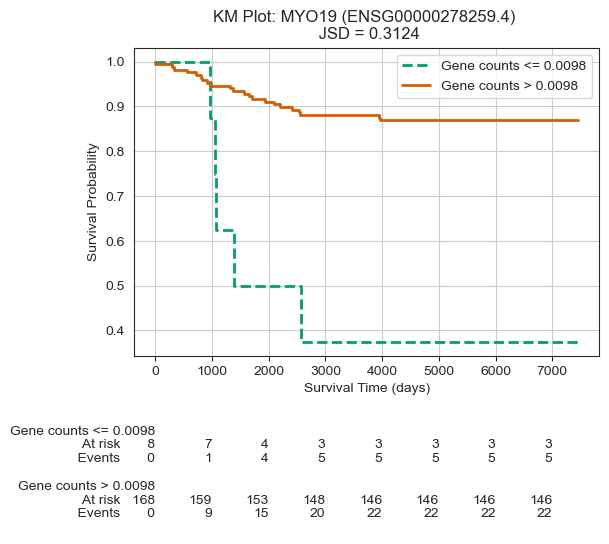

In [431]:
plot_km(gene_list_LumB[:5], filtered_df, subtype)

### Her2

In [454]:
subtype = 'Her2'
jsd_result = pd.read_csv(f'./result3/jsd_{subtype}.csv', sep=',')
jsd_result = jsd_result[jsd_result['JSD'] >= 0.4].sort_values(by='JSD', ascending=False)
jsd_result

,gene,threshold,JSD,size_le,size_he
1,ENSG00000000005.6,0.000657,0.693147,63.0,1.0
36683,ENSG00000243224.1,0.000000,0.693147,1.0,63.0
36589,ENSG00000242989.3,0.000008,0.693147,63.0,1.0
36594,ENSG00000242995.1,0.000018,0.693147,63.0,1.0
36598,ENSG00000243005.3,0.000023,0.693147,63.0,1.0
...,...,...,...,...,...
6474,ENSG00000131650.14,0.000182,0.400537,4.0,60.0
6472,ENSG00000131626.19,0.069175,0.400537,60.0,4.0
53642,ENSG00000276077.4,0.000000,0.400537,60.0,4.0
568,ENSG00000040487.13,0.003453,0.400537,4.0,60.0


In [455]:
# Filter result with balanced number of sample in each group
x = 61
filtered_df = jsd_result[abs(jsd_result['size_le'] - jsd_result['size_he']) <= x]
filtered_df

,gene,threshold,JSD,size_le,size_he
41834,ENSG00000254258.1,0.000012,0.693147,62.0,2.0
34409,ENSG00000237740.1,0.000029,0.693147,62.0,2.0
40180,ENSG00000252091.1,0.000007,0.693147,62.0,2.0
41186,ENSG00000253484.1,0.000000,0.693147,62.0,2.0
26763,ENSG00000226487.1,0.000000,0.693147,62.0,2.0
...,...,...,...,...,...
6474,ENSG00000131650.14,0.000182,0.400537,4.0,60.0
6472,ENSG00000131626.19,0.069175,0.400537,60.0,4.0
53642,ENSG00000276077.4,0.000000,0.400537,60.0,4.0
568,ENSG00000040487.13,0.003453,0.400537,4.0,60.0


In [457]:
# Get top gene lists
gene_list_Her2 = filtered_df.iloc[:, 0].to_list()
len(gene_list_Her2)

417

In [458]:
# Calculate bootstrap p-value for top genes
km_df = filtered_df.copy()
num_simulation = 5000
for gene in gene_list_Her2:
    ks_obs = filtered_df.loc[filtered_df['gene'] == gene, 'JSD'].iloc[0]
    jsd_sim, p_value = bootstrap_test(survival_time, ks_obs, num_simulation, subtype)
    km_df.loc[km_df['gene'] == gene, 'bootstrap_p'] = p_value

In [459]:
# Filter result with p-value
km_df = km_df[km_df['bootstrap_p'] <= 0.001]
km_df

,gene,threshold,JSD,size_le,size_he,bootstrap_p


In [460]:
# Get top gene lists
gene_list_Her2 = km_df.iloc[:, 0].to_list()
for gene in gene_list_Her2:
    print(gene_id_to_name.get(gene, gene))

In [461]:
plot_km(gene_list_Her2[:5], filtered_df, subtype)

### Basal

In [464]:
subtype = 'Basal'
jsd_result = pd.read_csv(f'./result3/jsd_{subtype}.csv', sep=',')
jsd_result = jsd_result[jsd_result['JSD'] >= 0.4].sort_values(by='JSD', ascending=False)
jsd_result

,gene,threshold,JSD,size_le,size_he
13002,ENSG00000171202.7,0.027177,0.693147,139.0,2.0
7147,ENSG00000135775.14,0.047330,0.693147,139.0,2.0
52340,ENSG00000273473.1,0.000466,0.693147,139.0,2.0
42878,ENSG00000255463.1,0.000043,0.693147,139.0,2.0
15609,ENSG00000183891.6,0.012711,0.693147,139.0,2.0
...,...,...,...,...,...
4299,ENSG00000114544.17,0.062018,0.419024,136.0,5.0
48263,ENSG00000265474.1,0.000006,0.419024,5.0,136.0
13667,ENSG00000174326.14,0.002051,0.419024,136.0,5.0
17571,ENSG00000197921.6,0.000151,0.414584,132.0,9.0


In [465]:
# Filter result with balanced number of sample in each group
x = 133
filtered_df = jsd_result[abs(jsd_result['size_le'] - jsd_result['size_he']) <= x]
filtered_df

,gene,threshold,JSD,size_le,size_he
19729,ENSG00000204054.14,0.028567,0.693147,137.0,4.0
28347,ENSG00000228834.1,0.000609,0.676548,137.0,4.0
36624,ENSG00000243056.2,0.000384,0.676548,137.0,4.0
28898,ENSG00000229671.3,0.000421,0.676548,137.0,4.0
6907,ENSG00000134461.16,0.012974,0.676548,137.0,4.0
23007,ENSG00000215018.10,0.000038,0.485745,7.0,134.0
42072,ENSG00000254548.1,0.000277,0.470903,134.0,7.0
46178,ENSG00000260805.2,0.005075,0.463589,135.0,6.0
3654,ENSG00000109265.14,0.000072,0.463589,6.0,135.0
56512,ENSG00000281832.1,0.000086,0.448273,135.0,6.0


In [466]:
# Get top gene lists
gene_list_Basal = filtered_df.iloc[:, 0].to_list()
len(gene_list_Basal)

27

In [470]:
# Calculate bootstrap p-value for top genes
km_df = filtered_df.copy()
num_simulation = 5000
for gene in gene_list_Basal:
    ks_obs = filtered_df.loc[filtered_df['gene'] == gene, 'JSD'].iloc[0]
    jsd_sim, p_value = bootstrap_test(survival_time, ks_obs, num_simulation, subtype)
    km_df.loc[km_df['gene'] == gene, 'bootstrap_p'] = p_value

In [472]:
# Filter result with p-value
km_df = km_df[km_df['bootstrap_p'] <= 0.001]
km_df

,gene,threshold,JSD,size_le,size_he,bootstrap_p


In [473]:
# Get top gene lists
gene_list_Basal = km_df.iloc[:, 0].to_list()
for gene in gene_list_Basal:
    print(gene_id_to_name.get(gene, gene))

In [474]:
plot_km(gene_list_Basal[:5], filtered_df, subtype)

### Normal-like

In [477]:
subtype = 'Normal'
jsd_result = pd.read_csv(f'./result3/jsd_{subtype}.csv', sep=',')
jsd_result = jsd_result[jsd_result['JSD'] >= 0.4].sort_values(by='JSD', ascending=False)
jsd_result

,gene,threshold,JSD,size_le,size_he
1,ENSG00000000005.6,0.000028,0.693147,1.0,24.0
37046,ENSG00000244076.1,0.000021,0.693147,24.0,1.0
37145,ENSG00000244294.3,0.000009,0.693147,24.0,1.0
37137,ENSG00000244274.8,0.000057,0.693147,1.0,24.0
37128,ENSG00000244259.1,0.000018,0.693147,24.0,1.0
...,...,...,...,...,...
13112,ENSG00000171658.8,0.000014,0.422810,5.0,20.0
55408,ENSG00000279328.1,0.000007,0.422810,5.0,20.0
43377,ENSG00000256574.8,0.000009,0.422810,5.0,20.0
44435,ENSG00000258603.4,0.000000,0.422810,5.0,20.0


In [478]:
# Filter result with balanced number of sample in each group
x = 24
filtered_df = jsd_result[abs(jsd_result['size_le'] - jsd_result['size_he']) <= x]
filtered_df

,gene,threshold,JSD,size_le,size_he
1,ENSG00000000005.6,0.000028,0.693147,1.0,24.0
37046,ENSG00000244076.1,0.000021,0.693147,24.0,1.0
37145,ENSG00000244294.3,0.000009,0.693147,24.0,1.0
37137,ENSG00000244274.8,0.000057,0.693147,1.0,24.0
37128,ENSG00000244259.1,0.000018,0.693147,24.0,1.0
...,...,...,...,...,...
13112,ENSG00000171658.8,0.000014,0.422810,5.0,20.0
55408,ENSG00000279328.1,0.000007,0.422810,5.0,20.0
43377,ENSG00000256574.8,0.000009,0.422810,5.0,20.0
44435,ENSG00000258603.4,0.000000,0.422810,5.0,20.0


In [479]:
# Get top gene lists
gene_list_Normal = filtered_df.iloc[:, 0].to_list()
len(gene_list_Normal)

8057

In [ ]:
# Calculate bootstrap p-value for top genes
km_df = filtered_df.copy()
num_simulation = 5000
for gene in gene_list_Normal:
    ks_obs = filtered_df.loc[filtered_df['gene'] == gene, 'JSD'].iloc[0]
    jsd_sim, p_value = bootstrap_test(survival_time, ks_obs, num_simulation, subtype)
    km_df.loc[km_df['gene'] == gene, 'bootstrap_p'] = p_value

In [ ]:
# Filter result with p-value
km_df = km_df[km_df['bootstrap_p'] <= 0.001]
km_df

,gene,threshold,JSD,size_le,size_he,bootstrap_p
4600,ENSG00000116691.11,0.004477,0.294701,10.0,409.0,0.0006
7000,ENSG00000135047.16,0.020322,0.294701,10.0,409.0,0.0006
16261,ENSG00000186501.14,0.012033,0.294701,10.0,409.0,0.0004
13964,ENSG00000175866.15,0.009278,0.294701,10.0,409.0,0.0010
2026,ENSG00000095380.11,0.010669,0.264139,11.0,408.0,0.0008
721,ENSG00000054148.18,0.010400,0.264139,11.0,408.0,0.0008
5794,ENSG00000126215.14,0.002074,0.264139,11.0,408.0,0.0004
10819,ENSG00000162747.12,0.000006,0.259981,13.0,406.0,0.0004
5997,ENSG00000128254.16,0.000059,0.259981,13.0,406.0,0.0004
58605,ENSG00000286177.1,0.000299,0.258469,11.0,408.0,0.0006


In [ ]:
# Get top gene lists
gene_list_Normal = km_df.iloc[:, 0].to_list()
for gene in gene_list_Normal:
    print(gene_id_to_name.get(gene, gene))

MIIP
CTSL
TMEM222
BAIAP2
NANS
PHPT1
XRCC3
FCGR3B
C22orf24
AC011462.5
ADCY1


In [ ]:
plot_km(gene_list_Normal[:5], filtered_df, subtype)

### Venn Diagram

<Figure size 1000x1000 with 0 Axes>

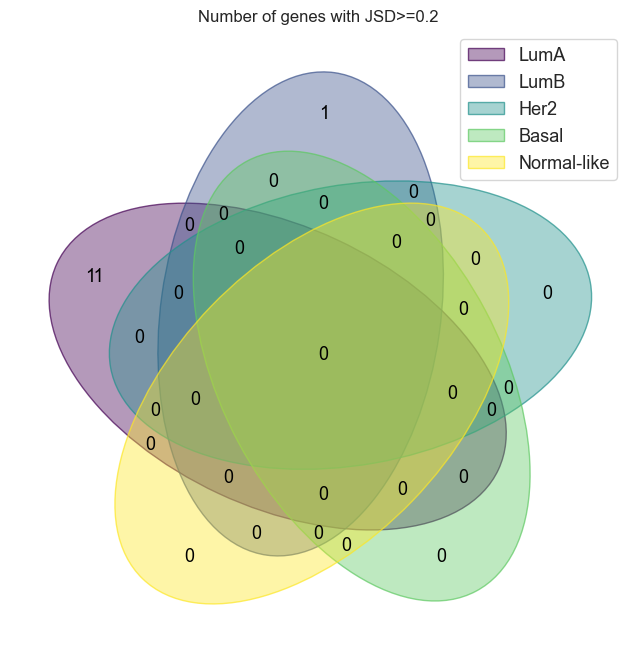

In [487]:
sets = {
    'LumA': set(gene_list_LumA),
    'LumB': set(gene_list_LumB),
    'Her2': set(gene_list_Her2),
    'Basal': set(gene_list_Basal),
    'Normal-like': set(gene_list_Normal),
}

# Plot the overall Venn diagram for all sets
plt.figure(figsize=(10, 10))
venn(sets)
plt.title('Number of genes with JSD>=0.2')
plt.show()

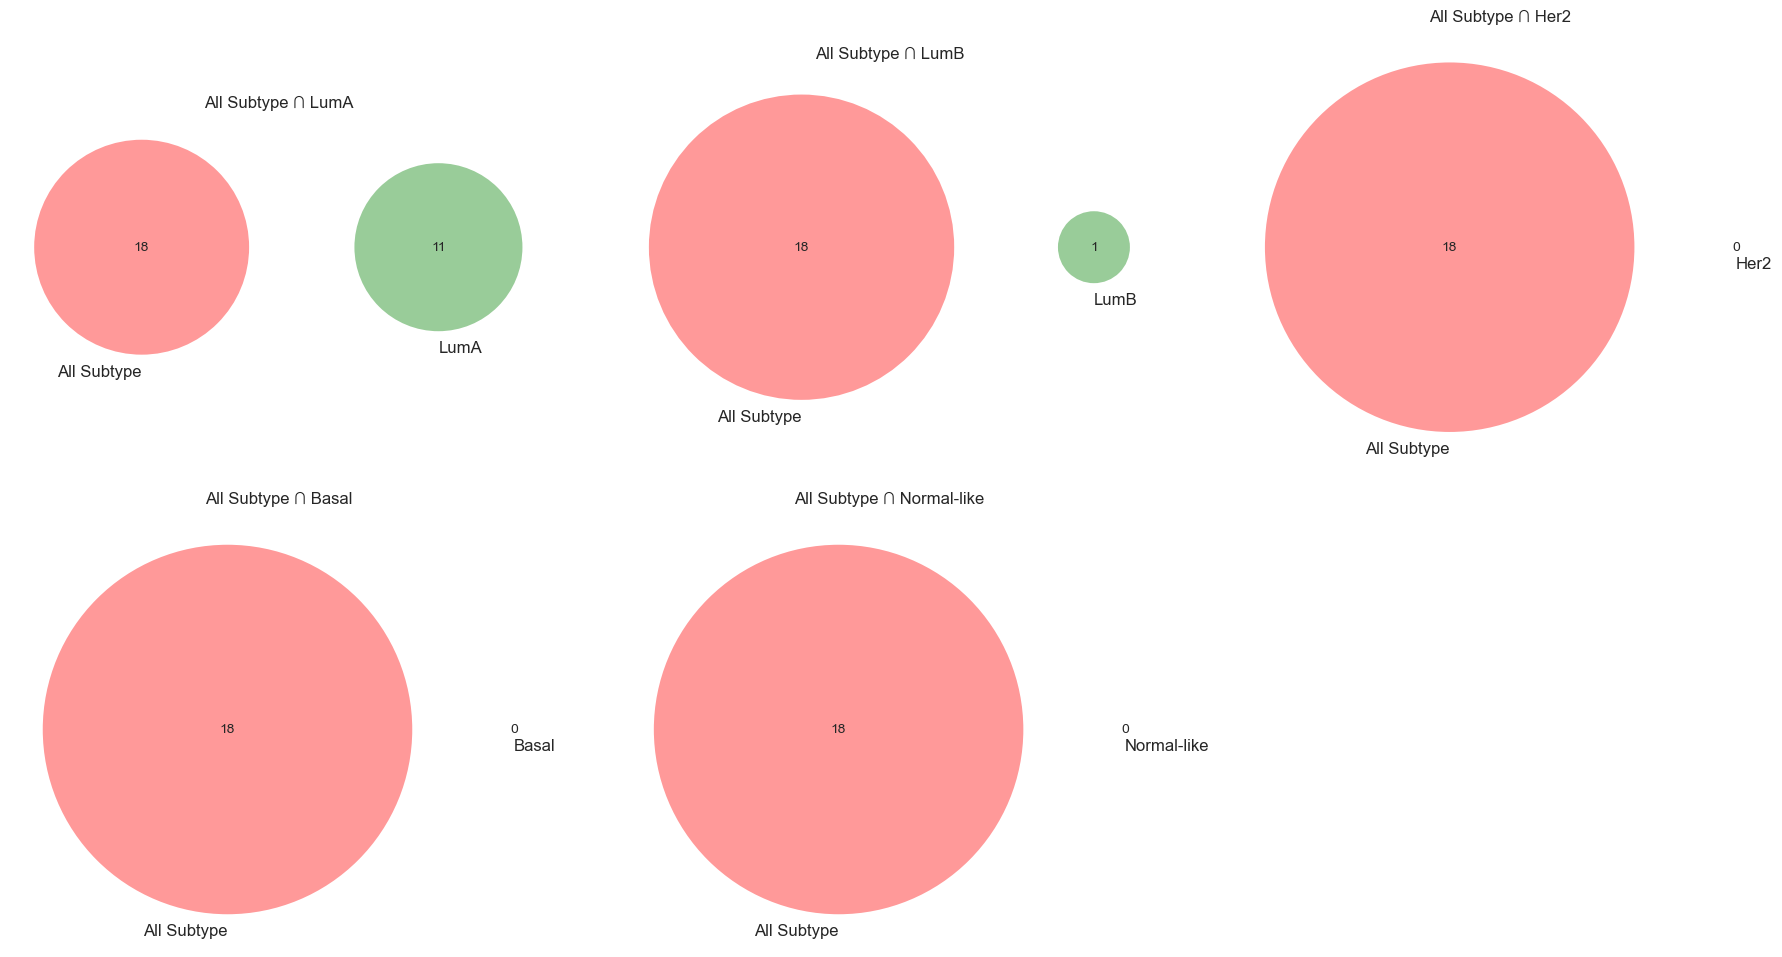

In [489]:
sets = {
    'All Subtype': set(gene_list_All),
    'LumA': set(gene_list_LumA),
    'LumB': set(gene_list_LumB),
    'Her2': set(gene_list_Her2),
    'Basal': set(gene_list_Basal),
    'Normal-like': set(gene_list_Normal),
}

# Fix 'All Subtype' and compare with the rest
fixed_set_name = 'All Subtype'
fixed_set = sets[fixed_set_name]

# Create a figure with 3x2 subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Flatten axes for easier indexing
axes = axes.flatten()

# Initialize plot index
plot_idx = 0

# Iterate through sets and plot Venn diagrams
for name, current_set in sets.items():
    if name != fixed_set_name:
        # Plot Venn diagram in the respective subplot
        venn2([fixed_set, current_set], set_labels=(fixed_set_name, name), ax=axes[plot_idx])
        axes[plot_idx].set_title(f'{fixed_set_name} ∩ {name}')
        plot_idx += 1

# Hide any remaining empty subplots if there are any
for i in range(plot_idx, len(axes)):
    axes[i].set_visible(False)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [490]:
# Find the maximum length of the gene sets to align them in columns
max_length = max(len(gene_set) for gene_set in sets.values())

# Create a DataFrame from the sets, padding shorter sets with NaN
df = pd.DataFrame({name: pd.Series(list(gene_set)).reindex(range(max_length)) for name, gene_set in sets.items()})

# Export the DataFrame to a CSV file
df.to_csv('./gene_sets_jsd.csv', index=False)

### Group similar expression

In [ ]:
gene = 'ENSG00000000419.13'
row = norm_data.loc[gene]
row

764     0.033998
1092    0.014106
742     0.012051
668     0.052486
783     0.014522
          ...   
821     0.017645
942     0.009661
251     0.015049
136     0.023812
173     0.021715
Name: ENSG00000000419.13, Length: 825, dtype: float64

In [ ]:
# Function to find the minimum difference between all expression levels
def find_min_difference(row):
    # Drop duplicate expression levels
    expression_values = row.drop_duplicates().values
    # Calculate pairwise differences
    diffs = np.abs(expression_values[:, None] - expression_values)
    np.fill_diagonal(diffs, np.inf)  # Ignore the diagonal (zero differences)
    return np.min(diffs)

# Function to group by similar expression levels
def group_similar(row, tolerance):  
    # Sort expression data for the specific gene
    gene_expression = row.sort_values()
    # Group similar expression values by rounding to tolerance
    rounding_factor = int(-np.log10(tolerance))
    expression_groups = gene_expression.round(decimals=rounding_factor)
    # Combine sample names with grouped expressions
    grouped_df = pd.DataFrame({'sample': gene_expression.index, 'expression': gene_expression.values, 'expression_group': expression_groups.values})   
    return grouped_df

min_difference = find_min_difference(row)
print(f"Minimum Difference: {min_difference}")

Minimum Difference: 9.999999999975306e-07


In [ ]:
# Define tolerance for grouping similar expression levels
tolerance = min_difference*1.1

df = group_similar(row, tolerance)

# Find min and max expression values from original df
min_val = df['expression'].min()
max_val = df['expression'].max()

# Remove random samples from each group while keeping at least one
balanced_df = df.groupby('expression_group').apply(lambda x: x.sample(n=1))

# Ensure min and max expression levels are not removed
if min_val not in balanced_df['expression'].values:
    min_row = df[df['expression'] == min_val]
    balanced_df = pd.concat([balanced_df, min_row])

if max_val not in balanced_df['expression'].values:
    max_row = df[df['expression'] == max_val]
    balanced_df = pd.concat([balanced_df, max_row])

# Drop the helper columns and reset index
balanced_df = balanced_df.drop(columns=['expression_group']).reset_index(drop=True)
balanced_df

/var/folders/nn/n9lqp7fs1pq402h_v1c984h40000gn/T/ipykernel_33409/435243307.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('expression_group').apply(lambda x: x.sample(n=1))


,sample,expression
0,398,0.004873
1,633,0.006091
2,174,0.006440
3,137,0.006531
4,578,0.006672
...,...,...
729,891,0.102053
730,412,0.106087
731,451,0.106893
732,781,0.111783


In [ ]:
# Expression levels in original DataFrame
original_expression_levels = set(df['expression'])

# Expression levels in balanced DataFrame
balanced_expression_levels = set(balanced_df['expression'])

# Check for removed rows
merged = pd.merge(df, balanced_df, how='left', indicator=True)
removed_rows = merged[merged['_merge'] == 'left_only']

print("Removed rows:")
print(len(removed_rows))
print(removed_rows[['sample', 'expression']])

Removed rows:
91
     sample  expression
18      614    0.009799
38     1077    0.011393
45      776    0.011628
46      444    0.011635
55      742    0.012051
..      ...         ...
656      58    0.032008
695     144    0.034198
697     318    0.034416
701     443    0.034549
761     427    0.041427

[91 rows x 2 columns]


In [ ]:
 # Summary statistics
print("\nOriginal DataFrame summary statistics:")
print(df['expression'].describe())

print("\nBalanced DataFrame summary statistics:")
print(balanced_df['expression'].describe())


Original DataFrame summary statistics:
count    825.000000
mean       0.025181
std        0.014295
min        0.004873
25%        0.016817
50%        0.022194
75%        0.029968
max        0.207114
Name: expression, dtype: float64

Balanced DataFrame summary statistics:
count    734.000000
mean       0.025726
std        0.014910
min        0.004873
25%        0.016928
50%        0.022751
75%        0.031054
max        0.207114
Name: expression, dtype: float64


/Users/tk/opt/anaconda3/envs/gene/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/tk/opt/anaconda3/envs/gene/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


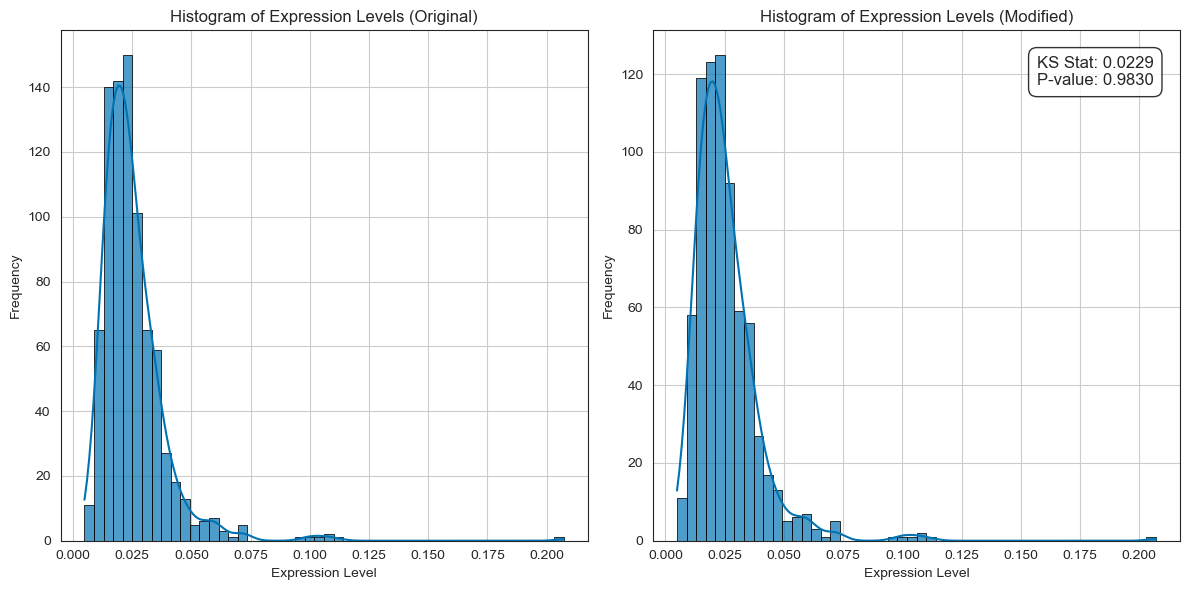

In [ ]:
# Perform KS test
stat, p_value = ks_2samp(df['expression'], balanced_df['expression'])
# print(f"KS Test Statistic: {stat:.4f}, p-value: {p_value:.4f}")

plt.figure(figsize=(12, 6))
# Original distribution histogram
plt.subplot(1, 2, 1)
sns.histplot(df['expression'], bins=50, kde=True, edgecolor='black', alpha=0.7)
plt.title('Histogram of Expression Levels (Original)')
plt.xlabel('Expression Level')
plt.ylabel('Frequency')
plt.grid(True)

# Modified distribution histogram
plt.subplot(1, 2, 2)
sns.histplot(balanced_df['expression'], bins=50, kde=True, edgecolor='black', alpha=0.7)
plt.title('Histogram of Expression Levels (Modified)')
plt.xlabel('Expression Level')
plt.ylabel('Frequency')
plt.grid(True)
plt.text(0.95, 0.95, f'KS Stat: {stat:.4f}\nP-value: {p_value:.4f}',
         horizontalalignment='right',
         verticalalignment='top',
         transform=plt.gca().transAxes,
         fontsize=12,
         bbox=dict(facecolor='white', edgecolor='black', alpha=0.8, boxstyle='round,pad=0.5'))
plt.tight_layout()
plt.show()

In [ ]:
gene_list = ['ENSG00000280670.3',
 'ENSG00000204264.12',
 'ENSG00000100219.16',
 'ENSG00000260924.2',
 'ENSG00000271550.1',
 'ENSG00000100503.26',
 'ENSG00000251411.1',
 'ENSG00000071859.15',
 'ENSG00000258910.3',
 'ENSG00000233203.6']
min_group_size = 1
results = []

for gene in gene_list:
    
    row = norm_data.loc[gene]

    # Find the minimum difference and define the tolerance for grouping
    min_difference = find_min_difference(row)
    tolerance = min_difference * 1.1

    # Group similar expression levels
    df = group_similar(row, tolerance)

    # Find the min and max expression values
    min_val, max_val = df['expression'].min(), df['expression'].max()

    # Balance the DataFrame by sampling one row per group)
    balanced_df = df.groupby('expression_group').apply(lambda x: x.sample(n=1))

    # Ensure min and max expression levels are not removed
    if min_val not in balanced_df['expression'].values:
        min_row = df[df['expression'] == min_val]
        balanced_df = pd.concat([balanced_df, min_row])

    if max_val not in balanced_df['expression'].values:
        max_row = df[df['expression'] == max_val]
        balanced_df = pd.concat([balanced_df, max_row])

    # Drop helper column and reset index
    balanced_df = balanced_df.drop(columns=['expression_group']).reset_index(drop=True)
    print(balanced_df.shape)

    # Transpose the DataFrame
    test = balanced_df.set_index('sample').T
    test.columns = test.columns.astype(int)
    test.reset_index(drop=True, inplace=True)
    columns_array = test.columns.to_numpy()
    test_array = test.values.ravel()
            
    # Initialize variables
    optimal_threshold = None
    lowest_pval = float('inf')
    highest_ks = float('-inf')
    size_le = None
    size_he = None
    
    # Loop through each value in the row to find the optimal threshold
    for threshold in test_array:
        
        le_mask = test_array <= threshold
        gt_mask = test_array > threshold

        # Extract column indices for each group
        group1_col = columns_array[le_mask]
        group2_col = columns_array[gt_mask]
        
        if len(group1_col) >= min_group_size and len(group2_col) >= min_group_size:
        
            # Extract the survival time where index matches the column names
            time_group1 = [key_to_time.get(key) for key in group1_col]
            time_group2 = [key_to_time.get(key) for key in group2_col]

            # Perform KS test
            ks_test = ks_2samp(np.array(time_group1), np.array(time_group2))
            ks_stat = round(ks_test.statistic, 4)
            ks_pval = round(ks_test.pvalue, 4)

            # Check if this p-value is the lowest
            if ks_pval < lowest_pval:
                highest_ks = ks_stat
                lowest_pval = ks_pval
                optimal_threshold = threshold
                size_le = len(time_group1)
                size_he = len(time_group2)

    # Store the results in the dictionary
    results.append({
        'gene': gene,
        'threshold': optimal_threshold,
        'pvalue': lowest_pval,
        'ks_statistic': highest_ks,
        'size_le': size_le,
        'size_he': size_he
    })

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)
results_df

/var/folders/nn/n9lqp7fs1pq402h_v1c984h40000gn/T/ipykernel_33409/3487654553.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('expression_group').apply(lambda x: x.sample(n=1))
/var/folders/nn/n9lqp7fs1pq402h_v1c984h40000gn/T/ipykernel_33409/3487654553.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('expression_group').apply(lambda x: x.sample(n=1))


(403, 2)
(784, 2)


/var/folders/nn/n9lqp7fs1pq402h_v1c984h40000gn/T/ipykernel_33409/3487654553.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('expression_group').apply(lambda x: x.sample(n=1))


(824, 2)


/var/folders/nn/n9lqp7fs1pq402h_v1c984h40000gn/T/ipykernel_33409/3487654553.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('expression_group').apply(lambda x: x.sample(n=1))
/var/folders/nn/n9lqp7fs1pq402h_v1c984h40000gn/T/ipykernel_33409/3487654553.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('expression_group').apply(lambda x: x.sample(n=1))


(128, 2)
(213, 2)
(775, 2)


/var/folders/nn/n9lqp7fs1pq402h_v1c984h40000gn/T/ipykernel_33409/3487654553.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('expression_group').apply(lambda x: x.sample(n=1))
/var/folders/nn/n9lqp7fs1pq402h_v1c984h40000gn/T/ipykernel_33409/3487654553.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('expression_group').apply(lambda x: x.sample(n=1))


(75, 2)
(775, 2)
(187, 2)
(79, 2)


/var/folders/nn/n9lqp7fs1pq402h_v1c984h40000gn/T/ipykernel_33409/3487654553.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('expression_group').apply(lambda x: x.sample(n=1))
/var/folders/nn/n9lqp7fs1pq402h_v1c984h40000gn/T/ipykernel_33409/3487654553.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('expression_group').apply(lambda x: x.sample(n=1))


,gene,threshold,pvalue,ks_statistic,size_le,size_he
0,ENSG00000280670.3,0.000437,0.0132,0.4613,11,392
1,ENSG00000204264.12,0.007327,0.0015,0.5051,13,771
2,ENSG00000100219.16,0.046318,0.0024,0.4891,13,811
3,ENSG00000260924.2,0.000043,0.4299,0.4113,4,124
4,ENSG00000271550.1,0.000062,0.0066,0.6990,5,208
5,ENSG00000100503.26,0.010694,0.0006,0.4631,18,757
6,ENSG00000251411.1,0.000009,0.0043,0.9726,2,73
7,ENSG00000071859.15,0.008904,0.0037,0.4584,14,761
8,ENSG00000258910.3,0.012926,0.0057,0.4558,173,14
9,ENSG00000233203.6,0.000011,0.0097,0.9481,2,77


In [ ]:
# Function to find the minimum difference between all expression levels
def find_min_difference(expression_values):
    # Vectorized computation of absolute differences using NumPy
    diffs = np.abs(expression_values.values[:, None] - expression_values.values)
    np.fill_diagonal(diffs, np.inf)  # Ignore the diagonal (self-differences)
    min_diff = np.min(diffs) if diffs.size else np.nan
    return min_diff

# Function to group by similar expression levels
def group_similar(gene_expression, tolerance):
    # Convert to DataFrame and sort by expression values in a single step
    gene_expression_df = pd.DataFrame({'sample': gene_expression.index, 'expression': gene_expression.values})
    gene_expression_df['expression_group'] = np.round(gene_expression_df['expression'] / tolerance) * tolerance
    return gene_expression_df

gene = 'ENSG00000134905.17'
row = norm_data.loc[gene].drop_duplicates()

# Find the minimum difference and define the tolerance for grouping
min_difference = find_min_difference(row)
tolerance = min_difference * 1.1

# Group similar expression levels
df = group_similar(row, tolerance)

# Find the min and max expression values
min_val, max_val = df['expression'].min(), df['expression'].max()

# Balance the DataFrame by sampling one row per group
balanced_df = df.groupby('expression_group', group_keys=False).apply(lambda x: x.sample(n=1))

# Ensure min and max expression levels are not removed
balanced_df = pd.concat([balanced_df, df[df['expression'].isin([min_val, max_val])]])

# Drop helper column and reset index
balanced_df = balanced_df.drop(columns=['expression_group']).reset_index(drop=True)

# Transpose the DataFrame and adjust column names
test = balanced_df.set_index('sample').T
test.columns = test.columns.astype(int)
test.reset_index(drop=True, inplace=True)
columns_array = test.columns.to_numpy()
test_array = test.values.ravel()
test

/var/folders/nn/n9lqp7fs1pq402h_v1c984h40000gn/T/ipykernel_33409/2093315112.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('expression_group', group_keys=False).apply(lambda x: x.sample(n=1))


sample,1065,490,120,135,208,776,137,669,829,880,...,1073,848,1047,997,470,417,394,600,1065,600
0,0.005978,0.006209,0.006887,0.006999,0.007119,0.007358,0.007458,0.007774,0.00809,0.008124,...,0.086994,0.087832,0.088443,0.089366,0.093934,0.096471,0.103303,0.17744,0.005978,0.17744


In [ ]:
test_array

array([0.005978, 0.006209, 0.006887, 0.006999, 0.007119, 0.007358,
       0.007458, 0.007774, 0.00809 , 0.008124, 0.008187, 0.00824 ,
       0.008377, 0.009141, 0.009181, 0.00928 , 0.00955 , 0.009604,
       0.009722, 0.009954, 0.009965, 0.009985, 0.010048, 0.010159,
       0.010407, 0.010453, 0.010465, 0.010551, 0.010606, 0.010736,
       0.010738, 0.010833, 0.011015, 0.011082, 0.011178, 0.01124 ,
       0.011373, 0.011392, 0.011401, 0.011436, 0.011461, 0.01148 ,
       0.011582, 0.01173 , 0.011793, 0.011859, 0.011903, 0.011922,
       0.011947, 0.011956, 0.011967, 0.011971, 0.012019, 0.012082,
       0.012108, 0.012183, 0.012251, 0.012303, 0.012323, 0.01239 ,
       0.012503, 0.012564, 0.012592, 0.012603, 0.012607, 0.01262 ,
       0.012638, 0.012706, 0.012753, 0.012758, 0.012885, 0.012887,
       0.012891, 0.012946, 0.012993, 0.013005, 0.013011, 0.013026,
       0.013035, 0.013069, 0.013075, 0.013206, 0.013228, 0.013417,
       0.013418, 0.013426, 0.013445, 0.013461, 0.013514, 0.013

In [ ]:
# Function to find the minimum difference between all expression levels
def find_min_difference(expression_values):
    # Vectorized computation of absolute differences using NumPy
    diffs = np.abs(expression_values.values[:, None] - expression_values.values)
    np.fill_diagonal(diffs, np.inf)  # Ignore the diagonal (self-differences)
    min_diff = np.min(diffs) if diffs.size else np.nan
    return min_diff

# Function to group by similar expression levels
def group_similar(gene_expression, tolerance):
    # Convert to DataFrame and sort by expression values in a single step
    gene_expression_df = pd.DataFrame({'sample': gene_expression.index, 'expression': gene_expression.values})
    gene_expression_df['expression_group'] = np.round(gene_expression_df['expression'] / tolerance) * tolerance
    return gene_expression_df

####
# Input
gene = 'ENSG00000134905.17'
row = norm_data.loc[gene].drop_duplicates()

# Find the minimum difference and define the tolerance for grouping
min_difference = find_min_difference(row)
tolerance = min_difference * 1.1

# Group similar expression levels
df = group_similar(row, tolerance)

# Find the min and max expression values
min_val, max_val = df['expression'].min(), df['expression'].max()

# Balance the DataFrame by sampling one row per group
balanced_df = df.groupby('expression_group', group_keys=False).apply(lambda x: x.sample(n=1))

# Ensure min and max expression levels are not removed
balanced_df = pd.concat([balanced_df, df[df['expression'].isin([min_val, max_val])]])

# Drop helper column and reset index
balanced_df = balanced_df.drop(columns=['expression_group']).reset_index(drop=True)

# Transpose the DataFrame and adjust column names
test = balanced_df.set_index('sample').T
test.columns = test.columns.astype(int)
test.reset_index(drop=True, inplace=True)

test

/var/folders/nn/n9lqp7fs1pq402h_v1c984h40000gn/T/ipykernel_33409/3572837735.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('expression_group', group_keys=False).apply(lambda x: x.sample(n=1))


sample,1065,490,120,135,208,776,137,669,829,880,...,1073,848,1047,997,470,417,394,600,1065,600
0,0.005978,0.006209,0.006887,0.006999,0.007119,0.007358,0.007458,0.007774,0.00809,0.008124,...,0.086994,0.087832,0.088443,0.089366,0.093934,0.096471,0.103303,0.17744,0.005978,0.17744


In [ ]:
# Convert DataFrame to a NumPy array
test_array = test.to_numpy().ravel()
test_array

array([0.005978, 0.006209, 0.006887, 0.006999, 0.007119, 0.007358,
       0.007458, 0.007774, 0.00809 , 0.008124, 0.008187, 0.00824 ,
       0.008377, 0.009141, 0.009181, 0.00928 , 0.00955 , 0.009604,
       0.009722, 0.009954, 0.009965, 0.009985, 0.010048, 0.010159,
       0.010407, 0.010453, 0.010465, 0.010551, 0.010606, 0.010736,
       0.010738, 0.010833, 0.011015, 0.011082, 0.011178, 0.01124 ,
       0.011373, 0.011392, 0.011401, 0.011436, 0.011461, 0.01148 ,
       0.011582, 0.01173 , 0.011793, 0.011859, 0.011903, 0.011922,
       0.011947, 0.011956, 0.011967, 0.011971, 0.012019, 0.012082,
       0.012108, 0.012183, 0.012251, 0.012303, 0.012323, 0.01239 ,
       0.012503, 0.012564, 0.012592, 0.012603, 0.012607, 0.01262 ,
       0.012638, 0.012706, 0.012753, 0.012758, 0.012885, 0.012887,
       0.012891, 0.012946, 0.012993, 0.013005, 0.013011, 0.013026,
       0.013035, 0.013069, 0.013075, 0.013206, 0.013228, 0.013417,
       0.013418, 0.013426, 0.013445, 0.013461, 0.013514, 0.013

In [ ]:
from scipy.stats import ks_2samp

# Convert to array
data = norm_data.values
columns_array = norm_data.columns.to_numpy()

gene_list = gene_id[:1]
min_group_size = 1
results = []

for gene in gene_list:
    
    # Get the index for the gene
    gene_idx = gene_to_index[gene]

    # Get the row where index = gene
    row = data[gene_idx]
    
    # Initialize variables
    optimal_threshold = None
    lowest_pval = float('inf')
    highest_ks = float('-inf')
    size_le = None
    size_he = None
    
    # Loop through each value in the row to find the optimal threshold
    for threshold in row:
        
        le_mask = row <= threshold
        gt_mask = row > threshold

        # Extract column indices for each group
        group1_col = columns_array[le_mask]
        group2_col = columns_array[gt_mask]
        
        if len(group1_col) >= min_group_size and len(group2_col) >= min_group_size:
        
            # Extract the survival time where index matches the column names
            time_group1 = [key_to_time.get(key) for key in group1_col]
            time_group2 = [key_to_time.get(key) for key in group2_col]

            # Perform KS test
            ks_test = ks_2samp(np.array(time_group1), np.array(time_group2))
            ks_stat = round(ks_test.statistic, 4)
            ks_pval = round(ks_test.pvalue, 4)

            # Check if this p-value is the lowest
            if ks_pval < lowest_pval:
                highest_ks = ks_stat
                lowest_pval = ks_pval
                optimal_threshold = threshold
                size_le = len(time_group1)
                size_he = len(time_group2)

    # Store the results in the dictionary
    results.append({
        'gene': gene,
        'threshold': optimal_threshold,
        'pvalue': lowest_pval,
        'ks_statistic': highest_ks,
        'size_le': size_le,
        'size_he': size_he
    })

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)
results_df

,gene,threshold,pvalue,ks_statistic,size_le,size_he
0,ENSG00000000003.15,0.014024,0.4321,0.0733,172,653
1,ENSG00000000005.6,0.000025,0.5868,0.0640,180,645
